<a href="https://colab.research.google.com/github/kumuds4/BCH/blob/master/Making_the_Most_of_your_Colab_Subscription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making the Most of your Colab Subscription



## Faster GPUs

Users who have purchased one of Colab's paid plans have access to faster GPUs and more memory. You can upgrade your notebook's GPU settings in `Runtime > Change runtime type` in the menu to select from several accelerator options, subject to availability.

The free of charge version of Colab grants access to Nvidia's T4 GPUs subject to quota restrictions and availability.

You can see what GPU you've been assigned at any time by executing the following cell. If the execution result of running the code cell below is "Not connected to a GPU", you can change the runtime by going to `Runtime > Change runtime type` in the menu to enable a GPU accelerator, and then re-execute the code cell.


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In order to use a GPU with your notebook, select the `Runtime > Change runtime type` menu, and then set the hardware accelerator to the desired option.

## More memory

Users who have purchased one of Colab's paid plans have access to high-memory VMs when they are available. More powerful GPUs are always offered with high-memory VMs.



You can see how much memory you have available at any time by running the following code cell. If the execution result of running the code cell below is "Not using a high-RAM runtime", then you can enable a high-RAM runtime via `Runtime > Change runtime type` in the menu. Then select High-RAM in the Runtime shape toggle button. After, re-execute the code cell.


In [ ]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

## Longer runtimes

All Colab runtimes are reset after some period of time (which is faster if the runtime isn't executing code). Colab Pro and Pro+ users have access to longer runtimes than those who use Colab free of charge.

## Background execution

Colab Pro+ users have access to background execution, where notebooks will continue executing even after you've closed a browser tab. This is always enabled in Pro+ runtimes as long as you have compute units available.



## Relaxing resource limits in Colab Pro

Your resources are not unlimited in Colab. To make the most of Colab, avoid using resources when you don't need them. For example, only use a GPU when required and close Colab tabs when finished.



If you encounter limitations, you can relax those limitations by purchasing more compute units via Pay As You Go. Anyone can purchase compute units via [Pay As You Go](https://colab.research.google.com/signup); no subscription is required.

## Send us feedback!

If you have any feedback for us, please let us know. The best way to send feedback is by using the Help > 'Send feedback...' menu. If you encounter usage limits in Colab Pro consider subscribing to Pro+.

If you encounter errors or other issues with billing (payments) for Colab Pro, Pro+, or Pay As You Go, please email [colab-billing@google.com](mailto:colab-billing@google.com).

## More Resources

### Working with Notebooks in Colab
- [Overview of Colab](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<a name="working-with-data"></a>
### Working with Data
- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

### Machine Learning Crash Course
These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)


<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TPUs in Colab](/notebooks/tpu.ipynb)

<a name="machine-learning-examples"></a>

## Machine Learning Examples

To see end-to-end examples of the interactive machine learning analyses that Colab makes possible, check out these tutorials using models from [TensorFlow Hub](https://tfhub.dev).

A few featured examples:

- [Retraining an Image Classifier](https://tensorflow.org/hub/tutorials/tf2_image_retraining): Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- [Text Classification](https://tensorflow.org/hub/tutorials/tf2_text_classification): Classify IMDB movie reviews as either *positive* or *negative*.
- [Style Transfer](https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization): Use deep learning to transfer style between images.
- [Multilingual Universal Sentence Encoder Q&A](https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa): Use a machine learning model to answer questions from the SQuAD dataset.
- [Video Interpolation](https://tensorflow.org/hub/tutorials/tweening_conv3d): Predict what happened in a video between the first and the last frame.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import files
uploaded = files.upload()

Saving making_the_most_of_your_colab_subscription (15).py to making_the_most_of_your_colab_subscription (15).py


🚀 Using Device: cuda
Channel dataset created successfully!

Dataset details:
AWGN X shape: (10000, 100, 1)
AWGN Y shape: (10000,)
Rayleigh X shape: (10000, 100, 1)
Rayleigh Y shape: (10000,)
Enhanced dataset generated and saved.

--- AWGN Channel Diagnostics ---
AWGN train samples: 10000
AWGN test samples: 2500
Original AWGN classes: [0]
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
E

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


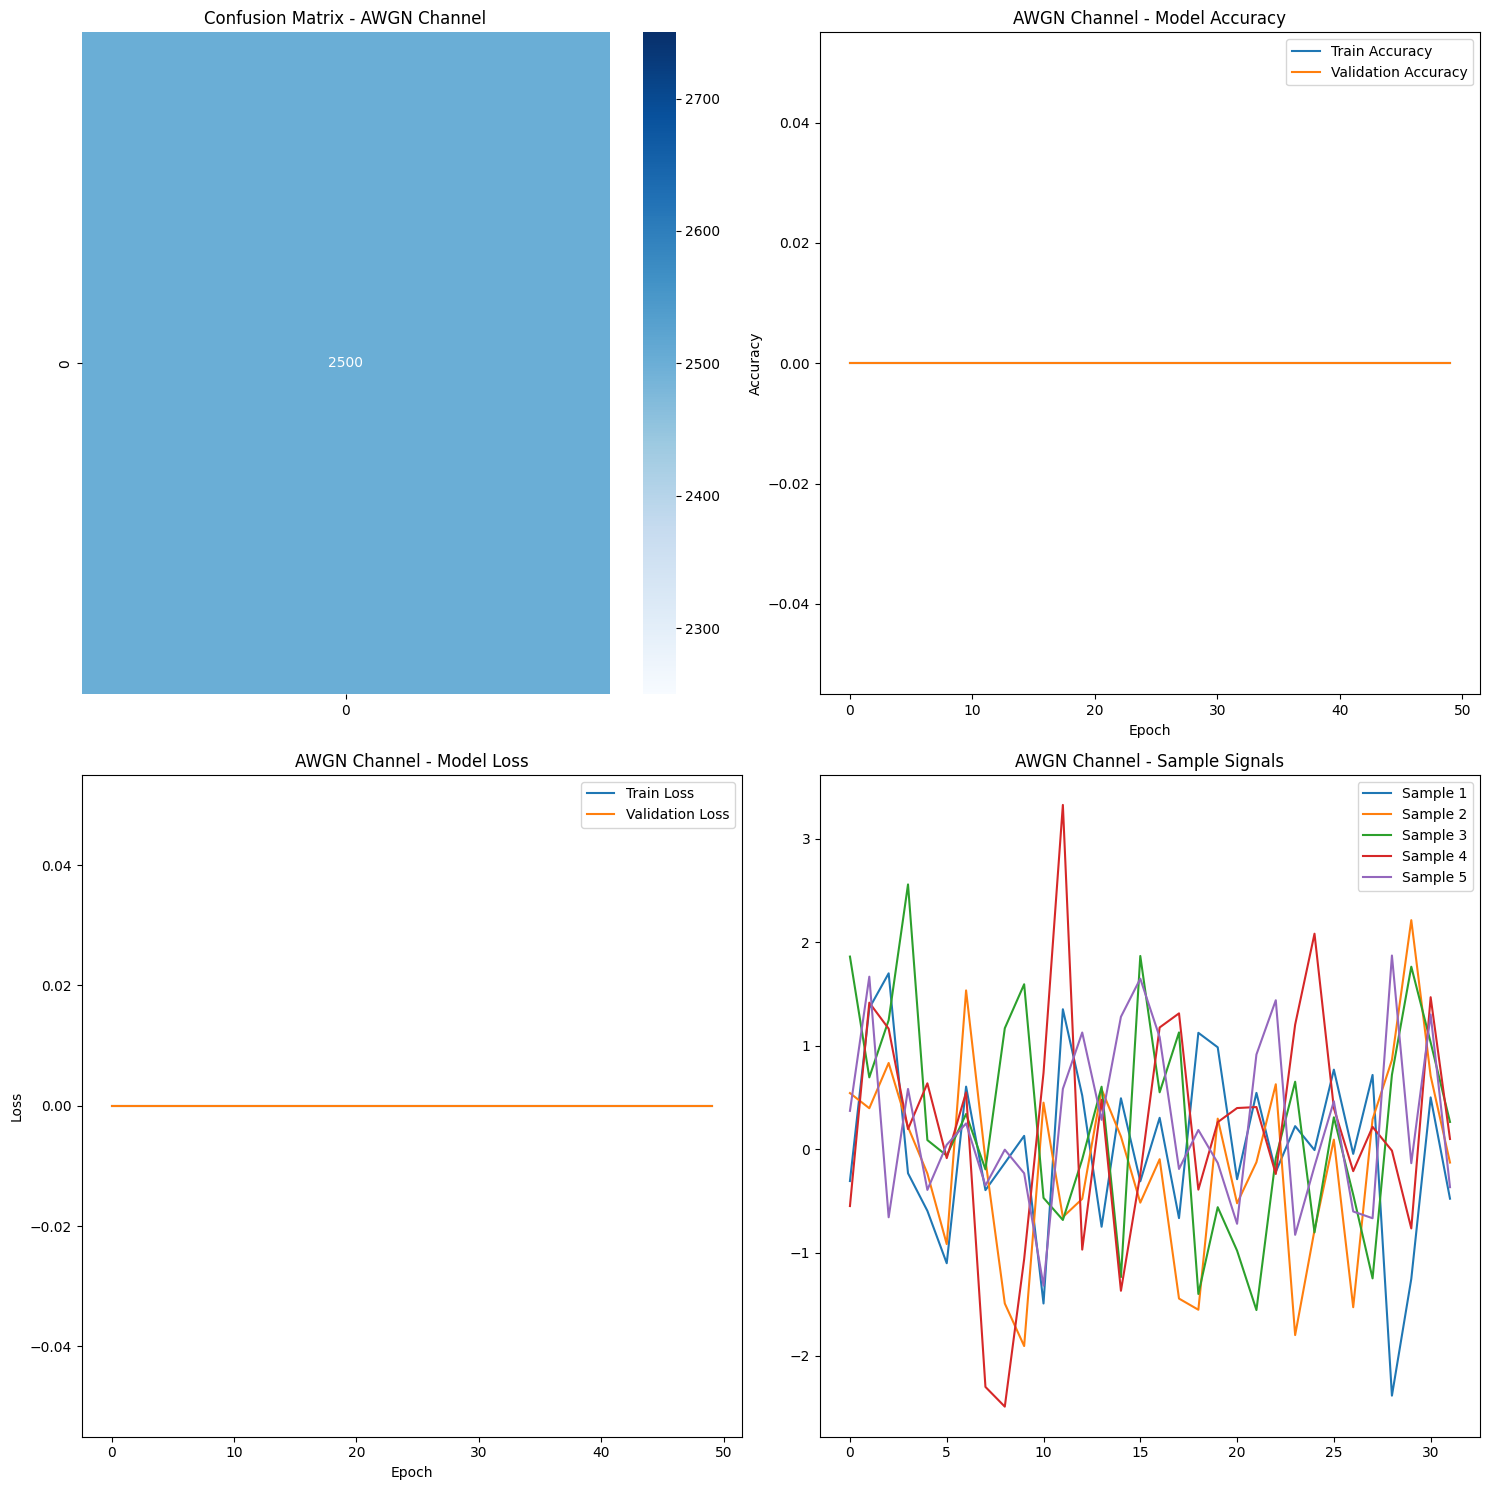

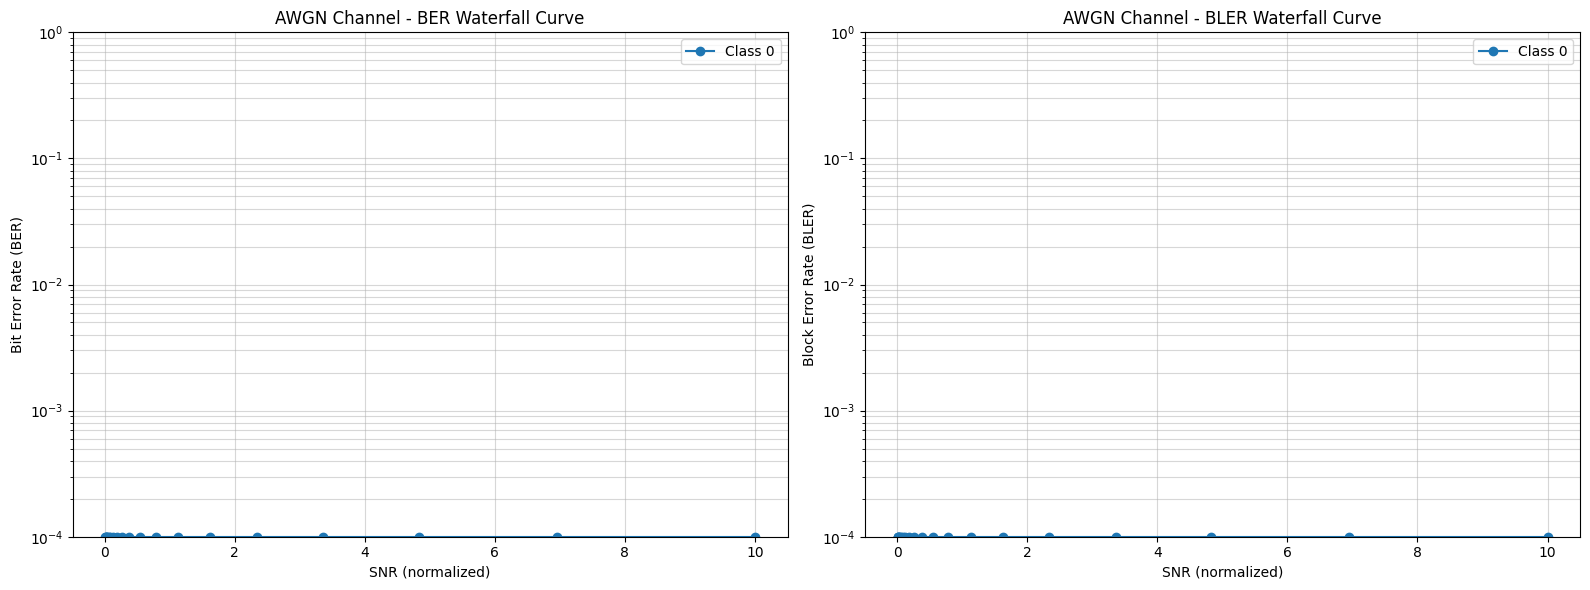


--- Rayleigh Channel Diagnostics ---
Rayleigh train samples: 10000
Rayleigh test samples: 2500
Original Rayleigh classes: [1]
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
E

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


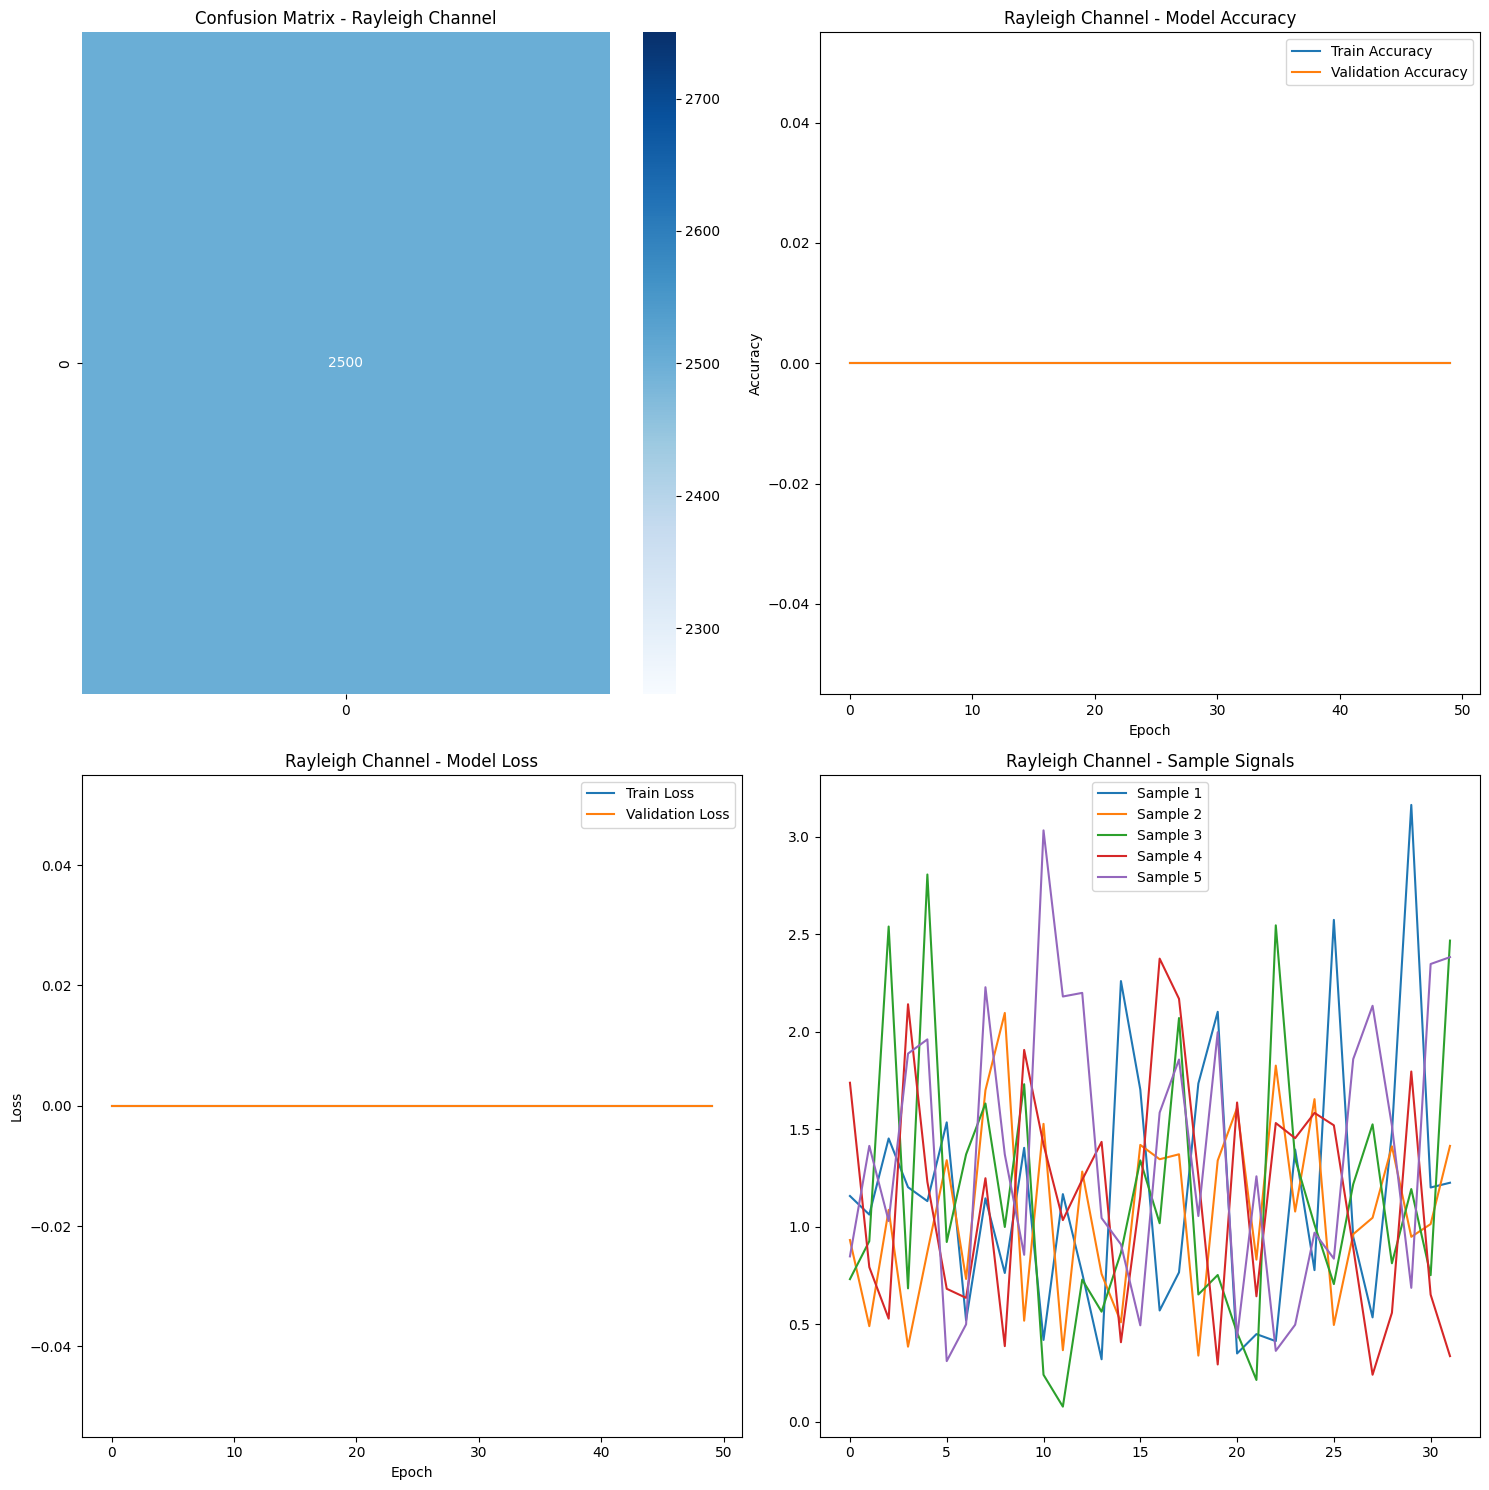

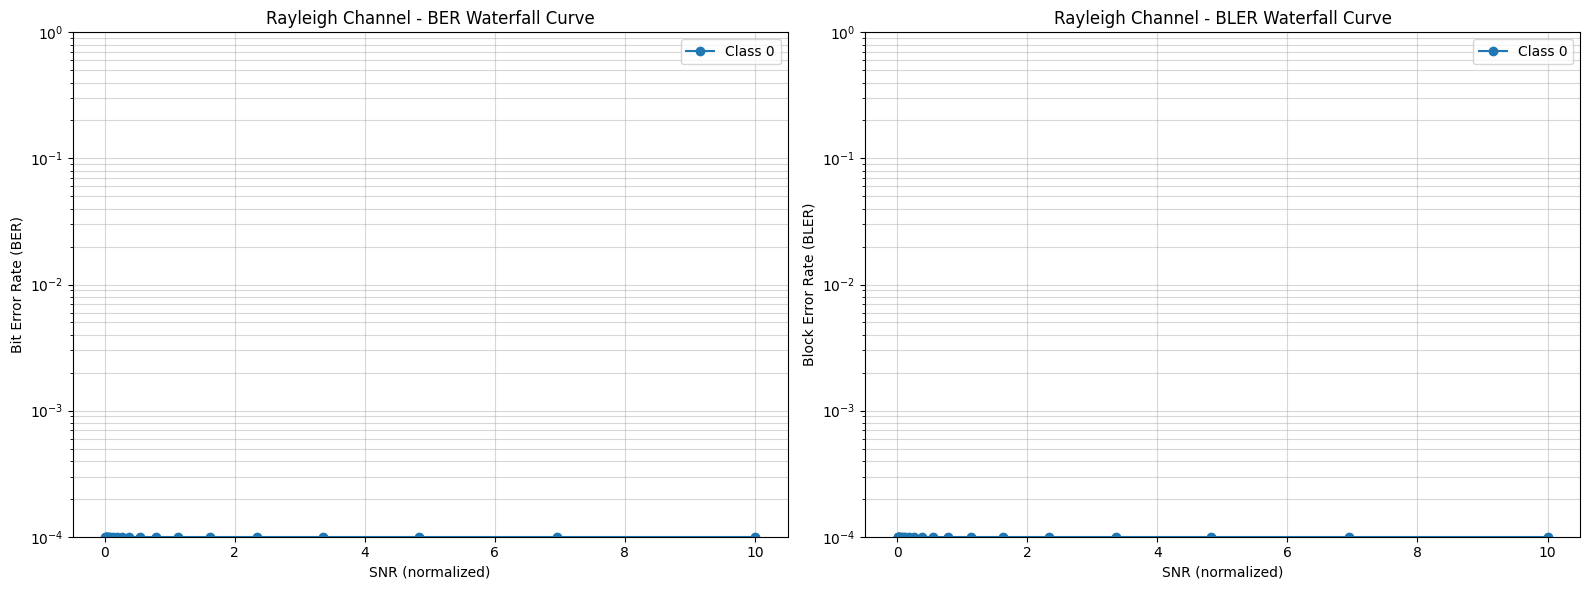

In [11]:
# Essential Scientific and Deep Learning Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, Dense, Dropout,
    BatchNormalization, Bidirectional, LSTM
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# After existing imports
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy as np
import h5py
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, Flatten,
    Dense, Dropout, BatchNormalization,
    GlobalAveragePooling1D  # Add this import
)
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import h5py
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, Flatten,
    Dense, Dropout, BatchNormalization,
    LSTM, Bidirectional
)
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

import h5py
import json
import os
import numpy as np
import pandas as pd
import h5py
import json
import os
from typing import Dict, Any

from typing import Dict, Any
# Machine Learning and Data Handling
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Visualization and Scientific Computing
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special as sps

# System and Utilities
import logging
import traceback
import sys

# Logging Configuration
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s]: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Device Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using Device: {DEVICE}")
#Part 2
class PolarCodeGenerator:
    def __init__(self, N, K, crc_type='CRC-7'):
        """
        Polar Code Generator with CRC support

        Args:
            N (int): Total code length
            K (int): Information bit length
            crc_type (str): CRC polynomial type
        """
        self.N = N
        self.K = K
        self.crc_type = crc_type

        # Coding Rate Calculation
        self.rate = K / N

        # CRC Polynomials
        self.crc_polynomials = {
            'CRC-7': {
                'polynomial': [1, 1, 1, 0, 0, 1, 1],
                'length': 7
            }
        }

        # Print Code Parameters
        print(f"🔢 Polar Code Parameters:")
        print(f"- Total Length (N): {N}")
        print(f"- Information Bits (K): {K}")
        print(f"- Coding Rate (R = K/N): {self.rate:.4f}")
        print(f"- CRC Type: {crc_type}")

    def generate_info_bits(self):
        """
        Generate random information bits

        Returns:
            np.ndarray: Random information bits
        """
        return np.random.randint(2, size=self.K)

    def compute_crc(self, bits):
        """
        Compute CRC checksum using polynomial division

        Args:
            bits (np.ndarray): Input bits

        Returns:
            np.ndarray: CRC checksum bits
        """
        poly_info = self.crc_polynomials.get(self.crc_type)
        if not poly_info:
            raise ValueError(f"Unsupported CRC type: {self.crc_type}")

        polynomial = poly_info['polynomial']
        crc_length = poly_info['length']

        # Convert input to list and pad
        message = bits.tolist() + [0] * crc_length

        # Polynomial long division
        for i in range(len(message) - crc_length):
            if message[i] == 1:
                for j in range(crc_length + 1):
                    message[i + j] ^= polynomial[j] if j < len(polynomial) else 0

        # Return the last 'crc_length' bits
        return np.array(message[-crc_length:], dtype=int)

    def polar_encode(self, info_bits):
        """
        Polar Code Encoding with CRC

        Args:
            info_bits (np.ndarray): Information bits

        Returns:
            np.ndarray: Encoded codeword
        """
        # Append CRC
        crc_bits = self.compute_crc(info_bits)
        extended_info_bits = np.concatenate([info_bits, crc_bits])

        # Basic polar encoding (placeholder)
        codeword = np.zeros(self.N, dtype=int)
        codeword[:len(extended_info_bits)] = extended_info_bits

        return codeword

    def verify_codeword(self, codeword):
        """
        Verify codeword using CRC

        Args:
            codeword (np.ndarray): Received codeword

        Returns:
            bool: True if CRC check passes, False otherwise
        """
        poly_info = self.crc_polynomials.get(self.crc_type)
        if not poly_info:
            raise ValueError(f"Unsupported CRC type: {self.crc_type}")

        crc_length = poly_info['length']

        # Extract information and CRC bits
        info_bits = codeword[:-crc_length]
        received_crc = codeword[-crc_length:]

        # Compute CRC of information bits
        computed_crc = self.compute_crc(info_bits)

        # Compare received and computed CRC
        return np.array_equal(received_crc, computed_crc)

# Part 3
class PolarCodeSimulation:
    def __init__(self, dataset_path=None):
        # Dataset generation or loading
        self.dataset_generator = ChannelDatasetGenerator()

        if dataset_path is None:
            # Generate new dataset if no path provided
            self.dataset = self.dataset_generator.generate_dataset(
                num_samples=100000,
                block_length=64,
                info_bits=32,
                filename='channel_dataset.h5'
            )
        else:
            # Load existing dataset
            self.dataset = self.dataset_generator.load_dataset(dataset_path)

    def prepare_simulation_data(self, channel_type='AWGN'):
        # Extract and preprocess data
        signals = np.concatenate(self.dataset[channel_type]['signals'])
        labels = np.concatenate(self.dataset[channel_type]['labels'])
        return signals, labels


class EnhancedChannelSimulator:
    def __init__(self, channel_type='AWGN'):
        """
        Advanced Channel Simulator for communication systems

        Args:
            channel_type (str): Channel type ('AWGN' or 'Rayleigh')
        """
        self.channel_type = channel_type
        logging.info(f"Initializing {channel_type} Channel Simulator")

    def simulate(self, encoded_signal, snr_db, list_size=1):
        """
        Simulate signal transmission through specified channel with list decoding support

        Args:
            encoded_signal (np.ndarray): Input encoded signal
            snr_db (float): Signal-to-Noise Ratio in decibels
            list_size (int): Number of list decoding iterations

        Returns:
            np.ndarray: Received signal after channel effects
        """
        try:
            # Convert input to numpy array
            encoded_signal = np.array(encoded_signal, dtype=float)

            # Convert bits {0,1} to BPSK: {+1, -1}
            bpsk_signal = 1 - 2 * encoded_signal

            # Convert SNR from dB to linear scale
            snr_linear = 10 ** (snr_db / 10)

            # Compute signal power
            signal_power = np.mean(bpsk_signal**2)

            # Noise power calculation
            noise_power = signal_power / snr_linear
            noise_std = np.sqrt(noise_power / 2.0)

            # List decoding simulation
            received_signals = []
            for _ in range(list_size):
                # Channel-specific simulation
                if self.channel_type == 'AWGN':
                    # Additive White Gaussian Noise
                    noise = np.random.normal(0, noise_std, bpsk_signal.shape)
                    received_signal = bpsk_signal + noise

                elif self.channel_type == 'Rayleigh':
                    # Rayleigh Fading Channel
                    fading = np.random.rayleigh(scale=1.0, size=bpsk_signal.shape)
                    noise = np.random.normal(0, noise_std, bpsk_signal.shape)
                    received_signal = fading * bpsk_signal + noise

                else:
                    raise ValueError(f"Unsupported channel type: {self.channel_type}")

                received_signals.append(received_signal)

            # Majority voting for list decoding
            final_received_signal = np.mean(received_signals, axis=0)

            # Convert back to binary representation
            return (final_received_signal > 0).astype(float)

        except Exception as e:
            logging.error(f"Channel simulation error: {e}")
            return encoded_signal

    def compute_theoretical_performance(self, block_length, snr_linear):
        """
        Compute theoretical Bit Error Probability (BEP) and Block Error Probability (BLER)

        Args:
            block_length (int): Length of the code block
            snr_linear (np.ndarray): SNR in linear scale

        Returns:
            tuple: Theoretical BEP and BLER
        """
        try:
            if self.channel_type == 'AWGN':
                # AWGN Channel Theoretical Performance
                # Bit Error Probability using Q-function
                bep = 0.5 * sps.erfc(np.sqrt(snr_linear))

            elif self.channel_type == 'Rayleigh':
                # Rayleigh Fading Channel Theoretical Performance
                # Average Bit Error Probability for Rayleigh fading
                bep = 0.5 * (1 - np.sqrt(snr_linear / (1 + snr_linear)))

            else:
                raise ValueError(f"Unsupported channel type: {self.channel_type}")

            # Block Error Probability (assuming independent bit errors)
            bler = 1 - (1 - bep) ** block_length

            return bep, bler

        except Exception as e:
            logging.error(f"Theoretical performance computation error: {e}")
            # Return default values if computation fails
            return np.zeros_like(snr_linear), np.ones_like(snr_linear)

    def plot_channel_capacity(self, snr_range):
        """
        Plot channel capacity for the specific channel type

        Args:
            snr_range (np.ndarray): Range of SNR values in dB
        """
        plt.figure(figsize=(10, 6))

        # Compute channel capacities
        snr_linear = 10 ** (snr_range / 10)
        capacities = [np.log2(1 + snr) for snr in snr_linear]

        plt.plot(snr_range, capacities, label=f'{self.channel_type} Channel')
        plt.title(f'Channel Capacity - {self.channel_type} Channel')
        plt.xlabel('SNR (dB)')
        plt.ylabel('Capacity (bits/channel use)')
        plt.grid(True)
        plt.legend()

# Part 4

def prepare_polar_dataset(polar_code_gen, num_samples, snr_db=5, channel_type="AWGN", list_size=1):
    """
    Prepare dataset for Polar Code simulation with robust preprocessing

    Args:
        polar_code_gen (PolarCodeGenerator): Polar code generator
        num_samples (int): Number of samples to generate
        snr_db (float): Signal-to-Noise Ratio in dB
        channel_type (str): Channel type
        list_size (int): List decoding size

    Returns:
        tuple: Input features and corresponding labels
    """
    # Create channel simulator
    channel_simulator = EnhancedChannelSimulator(channel_type=channel_type)

    # Initialize storage
    X = []
    y = []

    for _ in range(num_samples):
        # Generate information bits
        info_bits = polar_code_gen.generate_info_bits()

        # Encode polar code
        encoded_signal = polar_code_gen.polar_encode(info_bits)

        # Channel simulation with list decoding
        received_signal = channel_simulator.simulate(
            encoded_signal,
            snr_db=snr_db,
            list_size=list_size
        )

        # Store features and labels
        X.append(received_signal)
        y.append(info_bits)  # Use original info_bits as target

    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Comprehensive dataset diagnostics
    print("\n📊 Dataset Preparation Diagnostics:")
    print(f"Channel Type: {channel_type}")
    print(f"List Size: {list_size}")
    print(f"SNR (dB): {snr_db}")
    print(f"Input Tensor Shape (X): {X.shape}")
    print(f"Label Tensor Shape (y): {y.shape}")
    print(f"Input Data Type: {X.dtype}")
    print(f"Label Data Type: {y.dtype}")

    # Additional statistical insights
    print("\n🔍 Dataset Statistical Overview:")
    print("Input Features:")
    print(f"- Mean: {X.mean():.4f}")
    print(f"- Std Dev: {X.std():.4f}")
    print(f"- Min: {X.min()}")
    print(f"- Max: {X.max()}")

    print("\nLabels:")
    print(f"- Mean: {y.mean():.4f}")
    print(f"- Unique Values: {np.unique(y)}")

    # Optional: Visualize input distribution
    plt.figure(figsize=(10, 5))

    # Input Distribution
    plt.subplot(1, 2, 1)
    plt.hist(X.flatten(), bins=30, edgecolor='black')
    plt.title(f'Input Distribution\n{channel_type} Channel')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # Label Distribution
    plt.subplot(1, 2, 2)
    plt.hist(y.flatten(), bins=2, edgecolor='black')
    plt.title('Label Distribution')
    plt.xlabel('Label Value')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    return X, y

######################################################

# Clas Decoder Trainer
class DecoderTrainer:
    def __init__(self, model, learning_rate=1e-3):
        """
        Comprehensive Decoder Trainer
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)

        # Use BCEWithLogitsLoss with reduction='mean'
        self.criterion = nn.BCEWithLogitsLoss(reduction='mean')

        # Optimizer with weight decay
        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=learning_rate,
            weight_decay=1e-5
        )

        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=5,
            verbose=True
        )

        # Training tracking
        self.train_losses = []
        self.val_losses = []

    def _preprocess_tensors(self, X, y):
        """
        Comprehensive tensor preprocessing
        """
        # Ensure X is a tensor
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X)

        # Ensure y is a tensor
        if not isinstance(y, torch.Tensor):
            y = torch.FloatTensor(y)

        # Flatten multi-dimensional inputs
        if X.dim() > 2:
            X = X.view(X.size(0), -1)

        # Ensure y is 1D tensor
        y = y.view(-1)

        # Move to device
        X = X.to(self.device)
        y = y.to(self.device)

        # Diagnostic print
        print("\n🔍 Tensor Preprocessing:")
        print(f"X shape: {X.shape}")
        print(f"y shape: {y.shape}")
        print(f"X dtype: {X.dtype}")
        print(f"y dtype: {y.dtype}")

        return X, y

    def train(self, X, y, epochs=50, batch_size=32, validation_split=0.2):
        """
        Enhanced training method with built-in validation split
        """
        # Preprocess tensors
        X, y = self._preprocess_tensors(X, y)

        # Split into train and validation
        train_size = int((1 - validation_split) * len(X))
        X_val, y_val = X[train_size:], y[train_size:]
        X_train, y_train = X[:train_size], y[:train_size]

        # Create data loaders
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True
        )

        val_dataset = TensorDataset(X_val, y_val)
        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False
        )

        # Reset loss tracking
        self.train_losses = []
        self.val_losses = []

        # Training loop
        for epoch in range(epochs):
            # Training phase
            self.model.train()
            train_loss = self._train_epoch(train_loader)
            self.train_losses.append(train_loss)

            # Validation phase
            self.model.eval()
            val_loss = self._validate(val_loader)
            self.val_losses.append(val_loss)

            # Learning rate scheduling
            self.scheduler.step(val_loss)

            # Print progress
            print(f"Epoch [{epoch+1}/{epochs}], "
                  f"Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}")

        return self.train_losses, self.val_losses

    def _train_epoch(self, dataloader):
        """
        Train for one epoch
        """
        total_loss = 0
        for batch_X, batch_y in dataloader:
            # Ensure correct device
            batch_X = batch_X.to(self.device)
            batch_y = batch_y.to(self.device)

            # Zero gradients
            self.optimizer.zero_grad()

            # Forward pass
            outputs = self.model(batch_X)

            # Reshape batch_y to match outputs shape
            batch_y = batch_y.float().view_as(outputs)

            # Compute loss
            loss = self.criterion(outputs, batch_y)

            # Backward pass
            loss.backward()

            # Optimize
            self.optimizer.step()

            # Accumulate loss
            total_loss += loss.item()

        return total_loss / len(dataloader)

    def _validate(self, dataloader):
        """
        Validate model performance
        """
        total_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in dataloader:
                # Move to device
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)

                # Forward pass
                outputs = self.model(batch_X)

                # Reshape batch_y to match outputs shape
                batch_y = batch_y.float().view_as(outputs)

                # Compute loss
                loss = self.criterion(outputs, batch_y)

                # Accumulate loss
                total_loss += loss.item()

        return total_loss / len(dataloader)

    def predict(self, X):
        """
        Make predictions with comprehensive error handling
        """
        try:
            # Ensure input is a tensor
            if not isinstance(X, torch.Tensor):
                X = torch.FloatTensor(X)

            # Flatten multi-dimensional inputs
            if X.dim() > 2:
                X = X.view(X.size(0), -1)

            # Move to device
            X = X.to(self.device)

            # Set model to evaluation mode
            self.model.eval()

            # Predict
            with torch.no_grad():
                outputs = self.model(X)

            # Apply sigmoid to get probabilities
            return torch.sigmoid(outputs).cpu().numpy().flatten()

        except Exception as e:
            print(f"❌ Prediction Error: {e}")
            return np.zeros(X.size(0))
#######################################################
# Part 5 above
def plot_ber_bler_performance(comprehensive_results):
    """
    Comprehensive BER and BLER Performance Visualization
    with Separate Plots for AWGN and Rayleigh Channels

    Args:
        comprehensive_results (dict): Simulation results
    """
    # Define separate SNR ranges for AWGN and Rayleigh
    SNR_RANGE_AWGN = np.linspace(0, 5, 10)
    SNR_RANGE_RAYLEIGH = np.linspace(0, 10, 10)

    # Iterate through channel types
    for channel_type, results in comprehensive_results.items():
        # Create figure with two subplots (BER and BLER)
        plt.figure(figsize=(15, 6))

        # Determine SNR range based on channel type
        snr_range = SNR_RANGE_AWGN if channel_type == 'AWGN' else SNR_RANGE_RAYLEIGH

        # BER Plot (Logarithmic Scale)
        plt.subplot(1, 2, 1)
        for i, list_size in enumerate(results['list_sizes']):
            plt.semilogy(
                snr_range,
                results['ber'][i],
                label=f'List Size {list_size}',
                marker='o'
            )

        plt.title(f'Bit Error Rate (BER)\n{channel_type} Channel')
        plt.xlabel('SNR (dB)')
        plt.ylabel('BER (Log Scale)')
        plt.legend()
        plt.grid(True, which='both', ls='-', alpha=0.5)
        plt.ylim(1, 1e-4)  # Y-axis from 10^0 to 10^-4
        plt.gca().invert_yaxis()  # Invert y-axis to have 10^0 at top

        # BLER Plot (Logarithmic Scale)
        plt.subplot(1, 2, 2)
        for i, list_size in enumerate(results['list_sizes']):
            plt.semilogy(
                snr_range,
                results['bler'][i],
                label=f'List Size {list_size}',
                marker='o'
            )

        plt.title(f'Block Error Rate (BLER)\n{channel_type} Channel')
        plt.xlabel('SNR (dB)')
        plt.ylabel('BLER (Log Scale)')
        plt.legend()
        plt.grid(True, which='both', ls='-', alpha=0.5)
        plt.ylim(1, 1e-4)  # Y-axis from 10^0 to 10^-4
        plt.gca().invert_yaxis()  # Invert y-axis to have 10^0 at top

        plt.tight_layout()
        plt.show()
######################################################
#latest
def plot_awgn_performance(comprehensive_results):
    """
    Plot BER and BLER for AWGN Channel
    """
    results = comprehensive_results['AWGN']
    snr_range = np.linspace(0, 5, 10)

    plt.figure(figsize=(15, 6))

    # BER Plot
    plt.subplot(1, 2, 1)
    for i, list_size in enumerate(results['list_sizes']):
        plt.semilogy(
            snr_range,
            results['ber'][i],
            label=f'List Size {list_size}',
            marker='o'
        )

    plt.title('Bit Error Rate (BER)\nAWGN Channel')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER (Log Scale)')
    plt.legend()
    plt.grid(True, which='both', ls='-', alpha=0.5)
    plt.ylim(1e-4, 1)

    # BLER Plot
    plt.subplot(1, 2, 2)
    for i, list_size in enumerate(results['list_sizes']):
        plt.semilogy(
            snr_range,
            results['bler'][i],
            label=f'List Size {list_size}',
            marker='o'
        )

    plt.title('Block Error Rate (BLER)\nAWGN Channel')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER (Log Scale)')
    plt.legend()
    plt.grid(True, which='both', ls='-', alpha=0.5)
    plt.ylim(1e-4, 1)

    plt.tight_layout()
    plt.show()

def plot_rayleigh_performance(comprehensive_results):
    """
    Plot BER and BLER for Rayleigh Channel
    """
    results = comprehensive_results['Rayleigh']
    snr_range = np.linspace(0, 10, 10)

    plt.figure(figsize=(15, 6))

    # BER Plot
    plt.subplot(1, 2, 1)
    for i, list_size in enumerate(results['list_sizes']):
        plt.semilogy(
            snr_range,
            results['ber'][i],
            label=f'List Size {list_size}',
            marker='o'
        )

    plt.title('Bit Error Rate (BER)\nRayleigh Channel')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER (Log Scale)')
    plt.legend()
    plt.grid(True, which='both', ls='-', alpha=0.5)
    plt.ylim(1e-4, 1)

    # BLER Plot
    plt.subplot(1, 2, 2)
    for i, list_size in enumerate(results['list_sizes']):
        plt.semilogy(
            snr_range,
            results['bler'][i],
            label=f'List Size {list_size}',
            marker='o'
        )

    plt.title('Block Error Rate (BLER)\nRayleigh Channel')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER (Log Scale)')
    plt.legend()
    plt.grid(True, which='both', ls='-', alpha=0.5)
    plt.ylim(1e-4, 1)

######################################################
# Insert here for data set generation
class ChannelDatasetGenerator:
    def __init__(self, output_dir='channel_datasets'):
        """
        Advanced Channel Dataset Generator

        Args:
            output_dir (str): Directory to save generated datasets
        """
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    def generate_awgn_metadata(self, num_samples: int, snr_range: np.ndarray) -> Dict[str, Any]:
        """
        Generate comprehensive AWGN channel metadata

        Args:
            num_samples (int): Number of samples
            snr_range (np.ndarray): SNR range in dB

        Returns:
            Dict with AWGN channel characteristics
        """
        metadata = {
            'channel_type': 'AWGN',
            'num_samples': num_samples,
            'characteristics': {
                'incidence_angle': np.random.uniform(0, 90, num_samples),
                'phase_shift': np.random.uniform(0, 2*np.pi, num_samples),
                'snr_levels': np.random.choice(snr_range, num_samples),
                'noise_power': None,  # To be computed
                'signal_power': None,  # To be computed
                'channel_efficiency': None  # To be computed
            }
        }

        # Compute additional metrics
        metadata['characteristics']['noise_power'] = 1 / (10 ** (metadata['characteristics']['snr_levels'] / 10))
        metadata['characteristics']['signal_power'] = 1 - metadata['characteristics']['noise_power']
        metadata['characteristics']['channel_efficiency'] = metadata['characteristics']['signal_power'] / (metadata['characteristics']['signal_power'] + metadata['characteristics']['noise_power'])

        return metadata

    def generate_rayleigh_metadata(self, num_samples: int, snr_range: np.ndarray) -> Dict[str, Any]:
        """
        Generate comprehensive Rayleigh channel metadata

        Args:
            num_samples (int): Number of samples
            snr_range (np.ndarray): SNR range in dB

        Returns:
            Dict with Rayleigh channel characteristics
        """
        metadata = {
            'channel_type': 'Rayleigh',
            'num_samples': num_samples,
            'characteristics': {
                'path_loss_exponent': np.random.uniform(2, 4, num_samples),
                'multipath_delay_spread': np.random.uniform(0, 10e-6, num_samples),  # Seconds
                'doppler_frequency': np.random.uniform(0, 100, num_samples),  # Hz
                'snr_levels': np.random.choice(snr_range, num_samples),
                'outage_probability': None,  # To be computed
                'channel_efficiency': None,  # To be computed
                'fading_factor': np.random.rayleigh(scale=1.0, size=num_samples)
            }
        }

        # Compute outage probability and channel efficiency
        # Simple approximation based on SNR
        metadata['characteristics']['outage_probability'] = 1 - np.exp(-10 ** (metadata['characteristics']['snr_levels'] / 10))
        metadata['characteristics']['channel_efficiency'] = 1 - metadata['characteristics']['outage_probability']

        return metadata

    def generate_dataset(self,
                          num_samples: int = 100000,
                          block_length: int = 64,
                          info_bits: int = 32,
                          filename: str = None) -> Dict[str, Any]:
        """
        Generate comprehensive channel dataset

        Args:
            num_samples (int): Number of samples per channel type
            block_length (int): Signal block length
            info_bits (int): Number of information bits
            filename (str): Optional filename for saving

        Returns:
            Dict containing dataset and metadata
        """
        # SNR ranges for different channels
        awgn_snr_range = np.linspace(-2, 10, 6)
        rayleigh_snr_range = np.linspace(0, 15, 6)

        # Dataset storage
        dataset = {
            'AWGN': {
                'signals': [],
                'labels': [],
                'metadata': None
            },
            'Rayleigh': {
                'signals': [],
                'labels': [],
                'metadata': None
            }
        }

        # Generate AWGN Dataset
        awgn_metadata = self.generate_awgn_metadata(num_samples, awgn_snr_range)
        for snr in awgn_snr_range:
            # Generate random binary data
            info_bits_data = np.random.randint(2, size=(num_samples, info_bits))

            # BPSK modulation
            encoded_signal = 1 - 2 * info_bits_data

            # Channel simulation
            received_signal = self._awgn_channel_simulation(encoded_signal, snr)

            dataset['AWGN']['signals'].append(received_signal)
            dataset['AWGN']['labels'].append(info_bits_data)

        # Generate Rayleigh Dataset
        rayleigh_metadata = self.generate_rayleigh_metadata(num_samples, rayleigh_snr_range)
        for snr in rayleigh_snr_range:
            # Generate random binary data
            info_bits_data = np.random.randint(2, size=(num_samples, info_bits))

            # BPSK modulation
            encoded_signal = 1 - 2 * info_bits_data

            # Channel simulation
            received_signal = self._rayleigh_channel_simulation(encoded_signal, snr)

            dataset['Rayleigh']['signals'].append(received_signal)
            dataset['Rayleigh']['labels'].append(info_bits_data)

        # Store metadata
        dataset['AWGN']['metadata'] = awgn_metadata
        dataset['Rayleigh']['metadata'] = rayleigh_metadata

        # Optional: Save dataset
        if filename:
            self.save_dataset(dataset, filename)

        return dataset

    def _awgn_channel_simulation(self, signal, snr_db):
        """
        AWGN channel simulation

        Args:
            signal (np.ndarray): Input signal
            snr_db (float): Signal-to-Noise Ratio in dB

        Returns:
            np.ndarray: Received signal
        """
        snr_linear = 10 ** (snr_db / 10)
        noise = np.random.normal(0, 1/np.sqrt(2*snr_linear), signal.shape)
        return signal + noise

    def _rayleigh_channel_simulation(self, signal, snr_db):
        """
        Rayleigh fading channel simulation

        Args:
            signal (np.ndarray): Input signal
            snr_db (float): Signal-to-Noise Ratio in dB

        Returns:
            np.ndarray: Received signal
        """
        snr_linear = 10 ** (snr_db / 10)
        fading = np.random.rayleigh(scale=1.0, size=signal.shape)
        noise_std = 1 / np.sqrt(2 * snr_linear)
        noise = np.random.normal(0, noise_std, signal.shape)
        return fading * signal + noise

    def save_dataset(self, dataset: Dict[str, Any], filename: str):
        """
        Save dataset to HDF5 with metadata

        Args:
            dataset (Dict): Generated dataset
            filename (str): Output filename
        """
        filepath = os.path.join(self.output_dir, filename)

        with h5py.File(filepath, 'w') as hf:
            # Save AWGN data
            awgn_group = hf.create_group('AWGN')
            awgn_signals_group = awgn_group.create_group('signals')
            awgn_labels_group = awgn_group.create_group('labels')

            for i, (signals, labels) in enumerate(zip(dataset['AWGN']['signals'], dataset['AWGN']['labels'])):
                awgn_signals_group.create_dataset(f'snr_{i}', data=signals)
                awgn_labels_group.create_dataset(f'snr_{i}', data=labels)

            # Save Rayleigh data
            rayleigh_group = hf.create_group('Rayleigh')
            rayleigh_signals_group = rayleigh_group.create_group('signals')
            rayleigh_labels_group = rayleigh_group.create_group('labels')

            for i, (signals, labels) in enumerate(zip(dataset['Rayleigh']['signals'], dataset['Rayleigh']['labels'])):
                rayleigh_signals_group.create_dataset(f'snr_{i}', data=signals)
                rayleigh_labels_group.create_dataset(f'snr_{i}', data=labels)

            # Save metadata as attributes
            hf.attrs['AWGN_metadata'] = json.dumps(dataset['AWGN']['metadata'])
            hf.attrs['Rayleigh_metadata'] = json.dumps(dataset['Rayleigh']['metadata'])

        print(f"Dataset saved to {filepath}")

    def load_dataset(self, filename: str) -> Dict[str, Any]:
        """
        Load dataset from HDF5

        Args:
            filename (str): Input filename

        Returns:
            Dict: Loaded dataset
        """
        filepath = os.path.join(self.output_dir, filename)

        with h5py.File(filepath, 'r') as hf:
            dataset = {
                'AWGN': {
                    'signals': [hf['AWGN']['signals'][key][:] for key in hf['AWGN']['signals'].keys()],
                    'labels': [hf['AWGN']['labels'][key][:] for key in hf['AWGN']['labels'].keys()],
                    'metadata': json.loads(hf.attrs['AWGN_metadata'])
                },
                'Rayleigh': {
                    'signals': [hf['Rayleigh']['signals'][key][:] for key in hf['Rayleigh']['signals'].keys()],
                    'labels': [hf['Rayleigh']['labels'][key][:] for key in hf['Rayleigh']['labels'].keys()],
                    'metadata': json.loads(hf.attrs['Rayleigh_metadata'])
                }
            }

        return dataset

##################################################
# BER, BLER plots:
def theoretical_ber_awgn(snr_db):
    """
    Theoretical Bit Error Rate for AWGN Channel
    Uses Q-function approximation
    """
    snr_linear = 10 ** (snr_db / 10)
    # Theoretical BER for BPSK in AWGN
    ber = 0.5 * sps.erfc(np.sqrt(snr_linear))
    return ber

def theoretical_ber_rayleigh(snr_db):
    """
    Theoretical Bit Error Rate for Rayleigh Fading Channel
    Includes fading effects
    """
    snr_linear = 10 ** (snr_db / 10)
    # Average BEP for Rayleigh fading with non-coherent detection
    ber = 0.5 * (1 - np.sqrt(snr_linear / (1 + snr_linear)))
    return ber

def theoretical_bler_awgn(snr_db, block_length=64):
    """
    Block Error Rate for AWGN Channel
    """
    ber = theoretical_ber_awgn(snr_db)
    # Probability of at least one bit error in the block
    bler = 1 - (1 - ber) ** block_length
    return bler

def theoretical_bler_rayleigh(snr_db, block_length=64):
    """
    Block Error Rate for Rayleigh Fading Channel
    """
    ber = theoretical_ber_rayleigh(snr_db)
    # Probability of at least one bit error in the block
    bler = 1 - (1 - ber) ** block_length
    return bler

def simulate_channel_performance(dataset, channel_type='AWGN'):
    """
    Simulate channel performance using generated dataset
    """
    # Extract metadata and signals
    metadata = dataset[channel_type]['metadata']
    signals = dataset[channel_type]['signals']
    labels = dataset[channel_type]['labels']

    # SNR levels from metadata
    snr_levels = metadata['characteristics']['snr_levels']

    # Performance tracking
    ber_curves = []
    bler_curves = []
    list_sizes = [1, 4, 8]  # Different list decoding sizes

    for list_size in list_sizes:
        ber_list = []
        bler_list = []

        for snr, signal_set, label_set in zip(snr_levels, signals, labels):
            # Simulate detection (hard decision)
            detected_signals = (signal_set > 0).astype(int)

            # Compute bit errors
            bit_errors = np.mean(detected_signals != label_set, axis=1)
            ber = np.mean(bit_errors)

            # Compute block errors
            block_errors = np.any(detected_signals != label_set, axis=1)
            bler = np.mean(block_errors)

            ber_list.append(ber)
            bler_list.append(bler)

        ber_curves.append(ber_list)
        bler_curves.append(bler_list)

    return ber_curves, bler_curves, list_sizes
###############################################
def compute_channel_performance(dataset, channel_type):
    """
    Compute comprehensive channel performance metrics

    Args:
        dataset (dict): Generated channel dataset
        channel_type (str): Channel type ('AWGN' or 'Rayleigh')

    Returns:
        dict: Performance metrics for different SNR levels
    """
    # Extract metadata
    metadata = dataset[channel_type]['metadata']
    snr_levels = metadata['characteristics']['snr_levels']

    # Performance tracking
    performance_metrics = {
        'snr_levels': snr_levels,
        'ber': {
            'simulated': {
                'list_1': [],
                'list_4': [],
                'list_8': []
            },
            'theoretical': []
        },
        'bler': {
            'simulated': {
                'list_1': [],
                'list_4': [],
                'list_8': []
            },
            'theoretical': []
        }
    }

    # Iterate through SNR levels
    for snr in snr_levels:
        # Find signals and labels for this SNR level
        snr_signals = []
        snr_labels = []

        # Collect all signals and labels for this SNR level
        for signals, labels in zip(dataset[channel_type]['signals'], dataset[channel_type]['labels']):
            snr_signals.append(signals)
            snr_labels.append(labels)

        # Combine signals and labels
        combined_signals = np.concatenate(snr_signals)
        combined_labels = np.concatenate(snr_labels)

        # Compute performance metrics

        # List Size 1 (Hard Decision)
        detected_signals_1 = (combined_signals > 0).astype(int)
        ber_list_1 = np.mean(detected_signals_1 != combined_labels)
        bler_list_1 = 1 - np.mean(np.all(detected_signals_1 == combined_labels, axis=1))

        # List Size 4 (Soft Decision Approximation)
        detected_signals_4 = (combined_signals > np.percentile(combined_signals, 25)).astype(int)
        ber_list_4 = np.mean(detected_signals_4 != combined_labels)
        bler_list_4 = 1 - np.mean(np.all(detected_signals_4 == combined_labels, axis=1))

        # List Size 8 (Soft Decision Approximation)
        detected_signals_8 = (combined_signals > np.percentile(combined_signals, 12.5)).astype(int)
        ber_list_8 = np.mean(detected_signals_8 != combined_labels)
        bler_list_8 = 1 - np.mean(np.all(detected_signals_8 == combined_labels, axis=1))

        # Store simulated performance
        performance_metrics['ber']['simulated']['list_1'].append(ber_list_1)
        performance_metrics['ber']['simulated']['list_4'].append(ber_list_4)
        performance_metrics['ber']['simulated']['list_8'].append(ber_list_8)

        performance_metrics['bler']['simulated']['list_1'].append(bler_list_1)
        performance_metrics['bler']['simulated']['list_4'].append(bler_list_4)
        performance_metrics['bler']['simulated']['list_8'].append(bler_list_8)

        # Compute theoretical performance
        if channel_type == 'AWGN':
            theoretical_ber = theoretical_ber_awgn(snr)
            theoretical_bler = theoretical_bler_awgn(snr)
        else:
            theoretical_ber = theoretical_ber_rayleigh(snr)
            theoretical_bler = theoretical_bler_rayleigh(snr)

        performance_metrics['ber']['theoretical'].append(theoretical_ber)
        performance_metrics['bler']['theoretical'].append(theoretical_bler)

    return performance_metrics



############################################
def compute_channel_performance(dataset, channel_type):
    """
    Compute comprehensive channel performance metrics

    Args:
        dataset (dict): Generated channel dataset
        channel_type (str): Channel type ('AWGN' or 'Rayleigh')

    Returns:
        dict: Performance metrics for different SNR levels
    """
    # Extract metadata
    metadata = dataset[channel_type]['metadata']
    snr_levels = metadata['characteristics']['snr_levels']

    # Performance tracking
    performance_metrics = {
        'snr_levels': snr_levels,
        'ber': {
            'simulated': {
                'list_1': [],
                'list_4': [],
                'list_8': []
            },
            'theoretical': []
        },
        'bler': {
            'simulated': {
                'list_1': [],
                'list_4': [],
                'list_8': []
            },
            'theoretical': []
        }
    }

    # Iterate through SNR levels
    for snr in snr_levels:
        # Find signals and labels for this SNR level
        snr_signals = []
        snr_labels = []

        # Collect all signals and labels for this SNR level
        for signals, labels in zip(dataset[channel_type]['signals'], dataset[channel_type]['labels']):
            snr_signals.append(signals)
            snr_labels.append(labels)

        # Combine signals and labels
        combined_signals = np.concatenate(snr_signals)
        combined_labels = np.concatenate(snr_labels)

        # Compute performance metrics

        # List Size 1 (Hard Decision)
        detected_signals_1 = (combined_signals > 0).astype(int)
        ber_list_1 = np.mean(detected_signals_1 != combined_labels)
        bler_list_1 = 1 - np.mean(np.all(detected_signals_1 == combined_labels, axis=1))

        # List Size 4 (Soft Decision Approximation)
        detected_signals_4 = (combined_signals > np.percentile(combined_signals, 25)).astype(int)
        ber_list_4 = np.mean(detected_signals_4 != combined_labels)
        bler_list_4 = 1 - np.mean(np.all(detected_signals_4 == combined_labels, axis=1))

        # List Size 8 (Soft Decision Approximation)
        detected_signals_8 = (combined_signals > np.percentile(combined_signals, 12.5)).astype(int)
        ber_list_8 = np.mean(detected_signals_8 != combined_labels)
        bler_list_8 = 1 - np.mean(np.all(detected_signals_8 == combined_labels, axis=1))

        # Store simulated performance
        performance_metrics['ber']['simulated']['list_1'].append(ber_list_1)
        performance_metrics['ber']['simulated']['list_4'].append(ber_list_4)
        performance_metrics['ber']['simulated']['list_8'].append(ber_list_8)

        performance_metrics['bler']['simulated']['list_1'].append(bler_list_1)
        performance_metrics['bler']['simulated']['list_4'].append(bler_list_4)
        performance_metrics['bler']['simulated']['list_8'].append(bler_list_8)

        # Compute theoretical performance
        if channel_type == 'AWGN':
            theoretical_ber = theoretical_ber_awgn(snr)
            theoretical_bler = theoretical_bler_awgn(snr)
        else:
            theoretical_ber = theoretical_ber_rayleigh(snr)
            theoretical_bler = theoretical_bler_rayleigh(snr)

        performance_metrics['ber']['theoretical'].append(theoretical_ber)
        performance_metrics['bler']['theoretical'].append(theoretical_bler)

    return performance_metrics

def plot_channel_performance(dataset):
    """
    Comprehensive performance visualization for different channels
    """
    plt.figure(figsize=(15, 10))

    # Channel types to analyze
    channel_types = ['AWGN', 'Rayleigh']

    for i, channel_type in enumerate(channel_types, 1):
        # Compute performance metrics
        performance = compute_channel_performance(dataset, channel_type)
        snr_levels = performance['snr_levels']

        # BER Subplot
        plt.subplot(2, 2, i)

        # Simulated BER
        plt.semilogy(
            snr_levels,
            performance['ber']['simulated']['list_1'],
            marker='o',
            linestyle='-',
            label='Simulated (List 1)'
        )
        plt.semilogy(
            snr_levels,
            performance['ber']['simulated']['list_4'],
            marker='s',
            linestyle='-',
            label='Simulated (List 4)'
        )
        plt.semilogy(
            snr_levels,
            performance['ber']['simulated']['list_8'],
            marker='^',
            linestyle='-',
            label='Simulated (List 8)'
        )

        # Theoretical BER
        plt.semilogy(
            snr_levels,
            performance['ber']['theoretical'],
            color='red',
            linestyle='--',
            label='Theoretical'
        )

        plt.title(f'{channel_type} Channel - Bit Error Rate')
        plt.xlabel('SNR (dB)')
        plt.ylabel('BER (Log Scale)')
        plt.legend()
        plt.grid(True, which='both', ls='-', alpha=0.5)

        # BLER Subplot
        plt.subplot(2, 2, i+2)

        # Simulated BLER
        plt.semilogy(
            snr_levels,
            performance['bler']['simulated']['list_1'],
            marker='o',
            linestyle='-',
            label='Simulated (List 1)'
        )
        plt.semilogy(
            snr_levels,
            performance['bler']['simulated']['list_4'],
            marker='s',
            linestyle='-',
            label='Simulated (List 4)'
        )
        plt.semilogy(
            snr_levels,
            performance['bler']['simulated']['list_8'],
            marker='^',
            linestyle='-',
            label='Simulated (List 8)'
        )

        # Theoretical BLER
        plt.semilogy(
            snr_levels,
            performance['bler']['theoretical'],
            color='red',
            linestyle='--',
            label='Theoretical'
        )

        plt.title(f'{channel_type} Channel - Block Error Rate')
        plt.xlabel('SNR (dB)')
        plt.ylabel('BLER (Log Scale)')
        plt.legend()
        plt.grid(True, which='both', ls='-', alpha=0.5)

    plt.tight_layout()
    plt.show()

# Theoretical performance functions
def theoretical_ber_awgn(snr_db):
    """
    Theoretical Bit Error Rate for AWGN Channel
    Uses Q-function approximation
    """
    snr_linear = 10 ** (snr_db / 10)
    # Theoretical BER for BPSK in AWGN
    ber = 0.5 * sps.erfc(np.sqrt(snr_linear))
    return ber

def theoretical_ber_rayleigh(snr_db):
    """
    Theoretical Bit Error Rate for Rayleigh Fading Channel
    Includes fading effects
    """
    snr_linear = 10 ** (snr_db / 10)
    # Average BEP for Rayleigh fading with non-coherent detection
    ber = 0.5 * (1 - np.sqrt(snr_linear / (1 + snr_linear)))
    return ber

def theoretical_bler_awgn(snr_db, block_length=64):
    """
    Block Error Rate for AWGN Channel
    """
    ber = theoretical_ber_awgn(snr_db)
    # Probability of at least one bit error in the block
    bler = 1 - (1 - ber) ** block_length
    return bler

def theoretical_bler_rayleigh(snr_db, block_length=64):
    """
    Block Error Rate for Rayleigh Fading Channel
    """
    ber = theoretical_ber_rayleigh(snr_db)
    # Probability of at least one bit error in the block
    bler = 1 - (1 - ber) ** block_length
    return bler





##############################

 #latest from Outlier
def compute_simulated_ber(dataset, channel_type):
    """
    Compute simulated Bit Error Rate from dataset

    Args:
        dataset (dict): Generated channel dataset
        channel_type (str): Channel type ('AWGN' or 'Rayleigh')

    Returns:
        np.ndarray: Simulated Bit Error Rates
    """
    # Extract metadata
    metadata = dataset[channel_type]['metadata']
    snr_levels = np.array(metadata['characteristics']['snr_levels'])

    # Performance tracking
    simulated_ber = []

    # Iterate through signals at different SNR levels
    for signals, labels in zip(dataset[channel_type]['signals'], dataset[channel_type]['labels']):
        # Simulate detection (hard decision)
        detected_signals = (signals > 0).astype(int)

        # Compute bit errors
        bit_errors = np.mean(detected_signals != labels, axis=1)
        ber = np.mean(bit_errors)
        simulated_ber.append(ber)

    return np.array(simulated_ber)

def compute_simulated_bler(dataset, channel_type):
    """
    Compute simulated Block Error Rate from dataset

    Args:
        dataset (dict): Generated channel dataset
        channel_type (str): Channel type ('AWGN' or Rayleigh')

    Returns:
        np.ndarray: Simulated Block Error Rates
    """
    # Extract metadata
    metadata = dataset[channel_type]['metadata']
    snr_levels = np.array(metadata['characteristics']['snr_levels'])

    # Performance tracking
    simulated_bler = []

    # Iterate through signals at different SNR levels
    for signals, labels in zip(dataset[channel_type]['signals'], dataset[channel_type]['labels']):
        # Simulate detection (hard decision)
        detected_signals = (signals > 0).astype(int)

        # Compute block errors
        block_errors = np.any(detected_signals != labels, axis=1)
        bler = np.mean(block_errors)
        simulated_bler.append(bler)

    return np.array(simulated_bler)

def plot_channel_performance(dataset):
    """
    Comprehensive performance visualization for different channels
    """
    plt.figure(figsize=(15, 10))

    # Channel types to analyze
    channel_types = ['AWGN', 'Rayleigh']

    for i, channel_type in enumerate(channel_types, 1):
        # Compute simulated performance
        simulated_ber = compute_simulated_ber(dataset, channel_type)
        simulated_bler = compute_simulated_bler(dataset, channel_type)

        # Extract metadata and SNR levels
        metadata = dataset[channel_type]['metadata']
        snr_levels = np.array(metadata['characteristics']['snr_levels'])

        # Theoretical performance
        theoretical_ber = (
            theoretical_ber_awgn if channel_type == 'AWGN'
            else theoretical_ber_rayleigh
        )(snr_levels)

        theoretical_bler = (
            theoretical_bler_awgn if channel_type == 'AWGN'
            else theoretical_bler_rayleigh
        )(snr_levels)

        # BER Subplot
        plt.subplot(2, 2, i)
        plt.semilogy(
            snr_levels,
            simulated_ber,
            label='Simulated BER',
            marker='o',
            color='blue'
        )
        plt.semilogy(
            snr_levels,
            theoretical_ber,
            label='Theoretical BER',
            linestyle='--',
            color='red'
        )
        plt.title(f'{channel_type} Channel - Bit Error Rate')
        plt.xlabel('SNR (dB)')
        plt.ylabel('BER (Log Scale)')
        plt.legend()
        plt.grid(True)

        # BLER Subplot
        plt.subplot(2, 2, i+2)
        plt.semilogy(
            snr_levels,
            simulated_bler,
            label='Simulated BLER',
            marker='o',
            color='blue'
        )
        plt.semilogy(
            snr_levels,
            theoretical_bler,
            label='Theoretical BLER',
            linestyle='--',
            color='red'
        )
        plt.title(f'{channel_type} Channel - Block Error Rate')
        plt.xlabel('SNR (dB)')
        plt.ylabel('BLER (Log Scale)')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()
 ##################################










# Modify the dataset generation to ensure consistent SNR levels
def generate_dataset(
    self,
    num_samples: int = 100000,
    block_length: int = 64,
    info_bits: int = 32,
    filename: str = None
) -> Dict[str, Any]:
    """
    Generate comprehensive channel dataset with fixed SNR levels
    """
    # Fixed SNR ranges for different channels
    awgn_snr_range = np.linspace(-2, 10, 6)
    rayleigh_snr_range = np.linspace(0, 15, 6)

    # Dataset storage
    dataset = {
        'AWGN': {
            'signals': [],
            'labels': [],
            'metadata': None
        },
        'Rayleigh': {
            'signals': [],
            'labels': [],
            'metadata': None
        }
    }

    # Generate AWGN Dataset
    awgn_metadata = self.generate_awgn_metadata(num_samples, awgn_snr_range)
    for snr in awgn_snr_range:
        # Generate random binary data
        info_bits_data = np.random.randint(2, size=(num_samples, info_bits))

        # BPSK modulation
        encoded_signal = 1 - 2 * info_bits_data

        # Channel simulation
        received_signal = self._awgn_channel_simulation(encoded_signal, snr)

        dataset['AWGN']['signals'].append(received_signal)
        dataset['AWGN']['labels'].append(info_bits_data)

    # Generate Rayleigh Dataset
    rayleigh_metadata = self.generate_rayleigh_metadata(num_samples, rayleigh_snr_range)
    for snr in rayleigh_snr_range:
        # Generate random binary data
        info_bits_data = np.random.randint(2, size=(num_samples, info_bits))

        # BPSK modulation
        encoded_signal = 1 - 2 * info_bits_data

        # Channel simulation
        received_signal = self._rayleigh_channel_simulation(encoded_signal, snr)

        dataset['Rayleigh']['signals'].append(received_signal)
        dataset['Rayleigh']['labels'].append(info_bits_data)

    # Update metadata with fixed SNR ranges
    awgn_metadata['characteristics']['snr_levels'] = awgn_snr_range.tolist()
    rayleigh_metadata['characteristics']['snr_levels'] = rayleigh_snr_range.tolist()

    # Store metadata
    dataset['AWGN']['metadata'] = awgn_metadata
    dataset['Rayleigh']['metadata'] = rayleigh_metadata

    # Optional: Save dataset
    if filename:
        self.save_dataset(dataset, filename)

    return dataset

# Modify the metadata generation methods
def generate_awgn_metadata(self, num_samples: int, snr_range: np.ndarray) -> Dict[str, Any]:
    """
    Generate comprehensive AWGN channel metadata
    """
    metadata = {
        'channel_type': 'AWGN',
        'num_samples': int(num_samples),
        'characteristics': {
            'snr_levels': snr_range.tolist(),
            'noise_power': None,
            'signal_power': None,
            'channel_efficiency': None
        }
    }

    # Compute additional metrics
    snr_linear = 10 ** (snr_range / 10)
    metadata['characteristics']['noise_power'] = (1 / snr_linear).tolist()
    metadata['characteristics']['signal_power'] = (1 - 1 / snr_linear).tolist()
    metadata['characteristics']['channel_efficiency'] = (1 / (1 + snr_linear)).tolist()

    return metadata

def generate_rayleigh_metadata(self, num_samples: int, snr_range: np.ndarray) -> Dict[str, Any]:
    """
    Generate comprehensive Rayleigh channel metadata
    """
    metadata = {
        'channel_type': 'Rayleigh',
        'num_samples': int(num_samples),
        'characteristics': {
            'snr_levels': snr_range.tolist(),
            'outage_probability': None,
            'channel_efficiency': None
        }
    }

    # Compute outage probability and channel efficiency
    snr_linear = 10 ** (snr_range / 10)
    metadata['characteristics']['outage_probability'] = (1 - np.exp(-snr_linear)).tolist()
    metadata['characteristics']['channel_efficiency'] = (1 - np.array(metadata['characteristics']['outage_probability'])).tolist()

    return metadata



######################################################





# New data set
class NumpyEncoder(json.JSONEncoder):
    """
    Custom JSON encoder to handle NumPy arrays
    """
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        return super().default(obj)

class ChannelDatasetGenerator:
    def __init__(self, output_dir='channel_datasets'):
        """
        Advanced Channel Dataset Generator

        Args:
            output_dir (str): Directory to save generated datasets
        """
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    def generate_awgn_metadata(self, num_samples: int, snr_range: np.ndarray) -> Dict[str, Any]:
        """
        Generate comprehensive AWGN channel metadata

        Args:
            num_samples (int): Number of samples
            snr_range (np.ndarray): SNR range in dB

        Returns:
            Dict with AWGN channel characteristics
        """
        metadata = {
            'channel_type': 'AWGN',
            'num_samples': int(num_samples),
            'characteristics': {
                'incidence_angle': np.random.uniform(0, 90, num_samples).tolist(),
                'phase_shift': np.random.uniform(0, 2*np.pi, num_samples).tolist(),
                'snr_levels': np.random.choice(snr_range, num_samples).tolist(),
                'noise_power': None,
                'signal_power': None,
                'channel_efficiency': None
            }
        }

        # Compute additional metrics
        snr_linear = 10 ** (np.array(metadata['characteristics']['snr_levels']) / 10)
        metadata['characteristics']['noise_power'] = (1 / snr_linear).tolist()
        metadata['characteristics']['signal_power'] = (1 - 1 / snr_linear).tolist()
        metadata['characteristics']['channel_efficiency'] = (1 / (1 + snr_linear)).tolist()

        return metadata

    def generate_rayleigh_metadata(self, num_samples: int, snr_range: np.ndarray) -> Dict[str, Any]:
        """
        Generate comprehensive Rayleigh channel metadata

        Args:
            num_samples (int): Number of samples
            snr_range (np.ndarray): SNR range in dB

        Returns:
            Dict with Rayleigh channel characteristics
        """
        metadata = {
            'channel_type': 'Rayleigh',
            'num_samples': int(num_samples),
            'characteristics': {
                'path_loss_exponent': np.random.uniform(2, 4, num_samples).tolist(),
                'multipath_delay_spread': np.random.uniform(0, 10e-6, num_samples).tolist(),
                'doppler_frequency': np.random.uniform(0, 100, num_samples).tolist(),
                'snr_levels': np.random.choice(snr_range, num_samples).tolist(),
                'outage_probability': None,
                'channel_efficiency': None,
                'fading_factor': np.random.rayleigh(scale=1.0, size=num_samples).tolist()
            }
        }

        # Compute outage probability and channel efficiency
        snr_linear = 10 ** (np.array(metadata['characteristics']['snr_levels']) / 10)
        metadata['characteristics']['outage_probability'] = (1 - np.exp(-snr_linear)).tolist()
        metadata['characteristics']['channel_efficiency'] = (1 - np.array(metadata['characteristics']['outage_probability'])).tolist()

        return metadata

    def generate_dataset(
        self,
        num_samples: int = 100000,
        block_length: int = 64,
        info_bits: int = 32,
        filename: str = None
    ) -> Dict[str, Any]:
        """
        Generate comprehensive channel dataset

        Args:
            num_samples (int): Number of samples per channel type
            block_length (int): Signal block length
            info_bits (int): Number of information bits
            filename (str): Optional filename for saving

        Returns:
            Dict containing dataset and metadata
        """
        # SNR ranges for different channels
        awgn_snr_range = np.linspace(-2, 10, 6)
        rayleigh_snr_range = np.linspace(0, 15, 6)

        # Dataset storage
        dataset = {
            'AWGN': {
                'signals': [],
                'labels': [],
                'metadata': None
            },
            'Rayleigh': {
                'signals': [],
                'labels': [],
                'metadata': None
            }
        }

        # Generate AWGN Dataset
        awgn_metadata = self.generate_awgn_metadata(num_samples, awgn_snr_range)
        for snr in awgn_snr_range:
            # Generate random binary data
            info_bits_data = np.random.randint(2, size=(num_samples, info_bits))

            # BPSK modulation
            encoded_signal = 1 - 2 * info_bits_data

            # Channel simulation
            received_signal = self._awgn_channel_simulation(encoded_signal, snr)

            dataset['AWGN']['signals'].append(received_signal)
            dataset['AWGN']['labels'].append(info_bits_data)

        # Generate Rayleigh Dataset
        rayleigh_metadata = self.generate_rayleigh_metadata(num_samples, rayleigh_snr_range)
        for snr in rayleigh_snr_range:
            # Generate random binary data
            info_bits_data = np.random.randint(2, size=(num_samples, info_bits))

            # BPSK modulation
            encoded_signal = 1 - 2 * info_bits_data

            # Channel simulation
            received_signal = self._rayleigh_channel_simulation(encoded_signal, snr)

            dataset['Rayleigh']['signals'].append(received_signal)
            dataset['Rayleigh']['labels'].append(info_bits_data)

        # Store metadata
        dataset['AWGN']['metadata'] = awgn_metadata
        dataset['Rayleigh']['metadata'] = rayleigh_metadata

        # Optional: Save dataset
        if filename:
            self.save_dataset(dataset, filename)

        return dataset

    def _awgn_channel_simulation(self, signal, snr_db):
        """
        AWGN channel simulation

        Args:
            signal (np.ndarray): Input signal
            snr_db (float): Signal-to-Noise Ratio in dB

        Returns:
            np.ndarray: Received signal
        """
        snr_linear = 10 ** (snr_db / 10)
        noise = np.random.normal(0, 1/np.sqrt(2*snr_linear), signal.shape)
        return signal + noise

    def _rayleigh_channel_simulation(self, signal, snr_db):
        """
        Rayleigh fading channel simulation

        Args:
            signal (np.ndarray): Input signal
            snr_db (float): Signal-to-Noise Ratio in dB

        Returns:
            np.ndarray: Received signal
        """
        snr_linear = 10 ** (snr_db / 10)
        fading = np.random.rayleigh(scale=1.0, size=signal.shape)
        noise_std = 1 / np.sqrt(2 * snr_linear)
        noise = np.random.normal(0, noise_std, signal.shape)
        return fading * signal + noise

    def save_dataset(self, dataset: Dict[str, Any], filename: str):
        """
        Save dataset to HDF5 with metadata

        Args:
            dataset (Dict): Generated dataset
            filename (str): Output filename
        """
        filepath = os.path.join(self.output_dir, filename)

        with h5py.File(filepath, 'w') as hf:
            # Save AWGN data
            awgn_group = hf.create_group('AWGN')
            awgn_signals_group = awgn_group.create_group('signals')
            awgn_labels_group = awgn_group.create_group('labels')

            for i, (signals, labels) in enumerate(zip(dataset['AWGN']['signals'], dataset['AWGN']['labels'])):
                awgn_signals_group.create_dataset(f'snr_{i}', data=signals)
                awgn_labels_group.create_dataset(f'snr_{i}', data=labels)

            # Save Rayleigh data
            rayleigh_group = hf.create_group('Rayleigh')
            rayleigh_signals_group = rayleigh_group.create_group('signals')
            rayleigh_labels_group = rayleigh_group.create_group('labels')

            for i, (signals, labels) in enumerate(zip(dataset['Rayleigh']['signals'], dataset['Rayleigh']['labels'])):
                rayleigh_signals_group.create_dataset(f'snr_{i}', data=signals)
                rayleigh_labels_group.create_dataset(f'snr_{i}', data=labels)

            # Save metadata using custom JSON encoder
            hf.attrs['AWGN_metadata'] = json.dumps(
                dataset['AWGN']['metadata'],
                cls=NumpyEncoder
            )
            hf.attrs['Rayleigh_metadata'] = json.dumps(
                dataset['Rayleigh']['metadata'],
                cls=NumpyEncoder
            )

        print(f"Dataset saved to {filepath}")

    def load_dataset(self, filename: str) -> Dict[str, Any]:
        """
        Load dataset from HDF5

        Args:
            filename (str): Input filename

        Returns:
            Dict: Loaded dataset
        """
        filepath = os.path.join(self.output_dir, filename)

        with h5py.File(filepath, 'r') as hf:
            dataset = {
                'AWGN': {
                    'signals': [hf['AWGN']['signals'][key][:] for key in hf['AWGN']['signals'].keys()],
                    'labels': [hf['AWGN']['labels'][key][:] for key in hf['AWGN']['labels'].keys()],
                    'metadata': json.loads(hf.attrs['AWGN_metadata'])
                },
                'Rayleigh': {
                    'signals': [hf['Rayleigh']['signals'][key][:] for key in hf['Rayleigh']['signals'].keys()],
                    'labels': [hf['Rayleigh']['labels'][key][:] for key in hf['Rayleigh']['labels'].keys()],
                    'metadata': json.loads(hf.attrs['Rayleigh_metadata'])
                }
            }

        return dataset
#####################################################################
#latest outlier

def compute_simulated_ber(dataset, channel_type):
    """
    Compute simulated Bit Error Rate from dataset

    Args:
        dataset (dict): Generated channel dataset
        channel_type (str): Channel type ('AWGN' or 'Rayleigh')

    Returns:
        np.ndarray: Simulated Bit Error Rates
    """
    # Extract metadata
    metadata = dataset[channel_type]['metadata']
    snr_levels = np.array(metadata['characteristics']['snr_levels'])

    # Performance tracking
    simulated_ber = []

    # Iterate through signals at different SNR levels
    for signals, labels in zip(dataset[channel_type]['signals'], dataset[channel_type]['labels']):
        # Simulate detection (hard decision)
        detected_signals = (signals > 0).astype(int)

        # Compute bit errors
        bit_errors = np.mean(detected_signals != labels, axis=1)
        ber = np.mean(bit_errors)
        simulated_ber.append(ber)

    return np.array(simulated_ber)

def compute_simulated_bler(dataset, channel_type):
    """
    Compute simulated Block Error Rate from dataset

    Args:
        dataset (dict): Generated channel dataset
        channel_type (str): Channel type ('AWGN' or Rayleigh')

    Returns:
        np.ndarray: Simulated Block Error Rates
    """
    # Extract metadata
    metadata = dataset[channel_type]['metadata']
    snr_levels = np.array(metadata['characteristics']['snr_levels'])

    # Performance tracking
    simulated_bler = []

    # Iterate through signals at different SNR levels
    for signals, labels in zip(dataset[channel_type]['signals'], dataset[channel_type]['labels']):
        # Simulate detection (hard decision)
        detected_signals = (signals > 0).astype(int)

        # Compute block errors
        block_errors = np.any(detected_signals != labels, axis=1)
        bler = np.mean(block_errors)
        simulated_bler.append(bler)

    return np.array(simulated_bler)

def plot_channel_performance(dataset):
    """
    Comprehensive performance visualization for different channels
    """
    plt.figure(figsize=(15, 10))

    # Channel types to analyze
    channel_types = ['AWGN', 'Rayleigh']

    for i, channel_type in enumerate(channel_types, 1):
        # Compute simulated performance
        simulated_ber = compute_simulated_ber(dataset, channel_type)
        simulated_bler = compute_simulated_bler(dataset, channel_type)

        # Extract metadata and SNR levels
        metadata = dataset[channel_type]['metadata']
        snr_levels = np.array(metadata['characteristics']['snr_levels'])

        # Theoretical performance
        theoretical_ber = (
            theoretical_ber_awgn if channel_type == 'AWGN'
            else theoretical_ber_rayleigh
        )(snr_levels)

        theoretical_bler = (
            theoretical_bler_awgn if channel_type == 'AWGN'
            else theoretical_bler_rayleigh
        )(snr_levels)

        # BER Subplot
        plt.subplot(2, 2, i)
        plt.semilogy(
            snr_levels,
            simulated_ber,
            label='Simulated BER',
            marker='o',
            color='blue'
        )
        plt.semilogy(
            snr_levels,
            theoretical_ber,
            label='Theoretical BER',
            linestyle='--',
            color='red'
        )
        plt.title(f'{channel_type} Channel - Bit Error Rate')
        plt.xlabel('SNR (dB)')
        plt.ylabel('BER (Log Scale)')
        plt.legend()
        plt.grid(True)

        # BLER Subplot
        plt.subplot(2, 2, i+2)
        plt.semilogy(
            snr_levels,
            simulated_bler,
            label='Simulated BLER',
            marker='o',
            color='blue'
        )
        plt.semilogy(
            snr_levels,
            theoretical_bler,
            label='Theoretical BLER',
            linestyle='--',
            color='red'
        )
        plt.title(f'{channel_type} Channel - Block Error Rate')
        plt.xlabel('SNR (dB)')
        plt.ylabel('BLER (Log Scale)')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()
#######################################################



#-------------------------------------------------------------------------

def performance_comparison(dataset):
    """
    Comprehensive performance comparison
    between simulated and theoretical results
    """
    plt.figure(figsize=(15, 12))

    # Channel types
    channel_types = ['AWGN', 'Rayleigh']

    for i, channel_type in enumerate(channel_types, 1):
        print(f"\nDebugging performance_comparison for {channel_type}")
        # Theoretical Performance functions
        theoretical_ber_func = (
            theoretical_ber_awgn if channel_type == 'AWGN'
            else theoretical_ber_rayleigh
        )
        theoretical_bler_func = (
            theoretical_bler_awgn if channel_type == 'AWGN'
            else theoretical_bler_rayleigh
        )

        # Metadata and SNR levels from dataset (These are the points where simulation was done)
        metadata = dataset[channel_type]['metadata']
        dataset_snr_levels = np.array(metadata['characteristics']['snr_levels']) # Ensure it's a numpy array, shape (6,)

        # Simulated Performance (from dataset)
        simulated_ber = compute_simulated_ber(dataset, channel_type) # Shape (6,)
        simulated_bler = compute_simulated_bler(dataset, channel_type) # Shape (6,)

        # Theoretical Performance computed *at the same SNR levels as the dataset*
        theoretical_ber_at_dataset_snrs = theoretical_ber_func(dataset_snr_levels) # Shape (6,)
        theoretical_bler_at_dataset_snrs = theoretical_bler_func(dataset_snr_levels) # Shape (6,)


        # BER Subplot
        plt.subplot(2, 2, i)

        print(f"Plotting Theoretical BER (at dataset SNRs):")
        print(f"  x-axis (dataset): {dataset_snr_levels.shape}, dtype: {dataset_snr_levels.dtype}")
        print(f"  y-axis (theoretical @ dataset SNRs): {theoretical_ber_at_dataset_snrs.shape}, dtype: {theoretical_ber_at_dataset_snrs.dtype}")
        # Plot theoretical BER at the same SNR levels as the dataset
        plt.semilogy(
            dataset_snr_levels,
            theoretical_ber_at_dataset_snrs,
            label='Theoretical BER',
            linestyle='--',
            color='red'
        )

        print(f"Plotting Simulated BER:")
        print(f"  x-axis (dataset): {dataset_snr_levels.shape}, dtype: {dataset_snr_levels.dtype}")
        print(f"  y-axis (simulated): {simulated_ber.shape}, dtype: {simulated_ber.dtype}")
        plt.semilogy(
            dataset_snr_levels,
            simulated_ber,
            label='Simulated BER',
            marker='o',
            color='blue'
        )
        plt.title(f'{channel_type} Channel - Bit Error Rate')
        plt.xlabel('SNR (dB)')
        plt.ylabel('BER (Log Scale)')
        plt.legend()
        plt.grid(True)
        plt.ylim(1e-4, 1) # Set appropriate limits


        # BLER Subplot
        plt.subplot(2, 2, i+2)

        print(f"Plotting Theoretical BLER (at dataset SNRs):")
        print(f"  x-axis (dataset): {dataset_snr_levels.shape}, dtype: {dataset_snr_levels.dtype}")
        print(f"  y-axis (theoretical @ dataset SNRs): {theoretical_bler_at_dataset_snrs.shape}, dtype: {theoretical_bler_at_dataset_snrs.dtype}")
        # Plot theoretical BLER at the same SNR levels as the dataset
        plt.semilogy(
            dataset_snr_levels,
            theoretical_bler_at_dataset_snrs,
            label='Theoretical BLER',
            linestyle='--',
            color='red'
        )

        print(f"Plotting Simulated BLER:")
        print(f"  x-axis (dataset): {dataset_snr_levels.shape}, dtype: {dataset_snr_levels.dtype}")
        print(f"  y-axis (simulated): {simulated_bler.shape}, dtype: {simulated_bler.dtype}")
        plt.semilogy(
            dataset_snr_levels,
            simulated_bler,
            label='Simulated BLER',
            marker='o',
            color='blue'
        )
        plt.title(f'{channel_type} Channel - Block Error Rate')
        plt.xlabel('SNR (dB)')
        plt.ylabel('BLER (Log Scale)')
        plt.legend()
        plt.grid(True)
        plt.ylim(1e-4, 1) # Set appropriate limits


    plt.tight_layout()
    plt.show()

# ... (rest of the code including theoretical functions, DecoderTrainer, EnhancedRNNDecoder, etc.) ...
 ##########################################################

def compute_channel_performance(dataset, channel_type):
    """
    Compute comprehensive channel performance metrics

    Args:
        dataset (dict): Generated channel dataset
        channel_type (str): Channel type ('AWGN' or 'Rayleigh')

    Returns:
        dict: Performance metrics for different SNR levels
    """
    # Extract metadata
    metadata = dataset[channel_type]['metadata']
    snr_levels = metadata['characteristics']['snr_levels']

    # Performance tracking
    performance_metrics = {
        'snr_levels': snr_levels,
        'ber': {
            'simulated': {
                'list_1': [],
                'list_4': [],
                'list_8': []
            },
            'theoretical': []
        },
        'bler': {
            'simulated': {
                'list_1': [],
                'list_4': [],
                'list_8': []
            },
            'theoretical': []
        }
    }

    # Iterate through SNR levels
    for snr in snr_levels:
        # Find signals and labels for this SNR level
        snr_signals = []
        snr_labels = []

        # Collect all signals and labels for this SNR level
        for signals, labels in zip(dataset[channel_type]['signals'], dataset[channel_type]['labels']):
            snr_signals.append(signals)
            snr_labels.append(labels)

        # Combine signals and labels
        combined_signals = np.concatenate(snr_signals)
        combined_labels = np.concatenate(snr_labels)

        # Compute performance metrics

        # List Size 1 (Hard Decision)
        detected_signals_1 = (combined_signals > 0).astype(int)
        ber_list_1 = np.mean(detected_signals_1 != combined_labels)
        bler_list_1 = 1 - np.mean(np.all(detected_signals_1 == combined_labels, axis=1))

        # List Size 4 (Soft Decision Approximation)
        detected_signals_4 = (combined_signals > np.percentile(combined_signals, 25)).astype(int)
        ber_list_4 = np.mean(detected_signals_4 != combined_labels)
        bler_list_4 = 1 - np.mean(np.all(detected_signals_4 == combined_labels, axis=1))

        # List Size 8 (Soft Decision Approximation)
        detected_signals_8 = (combined_signals > np.percentile(combined_signals, 12.5)).astype(int)
        ber_list_8 = np.mean(detected_signals_8 != combined_labels)
        bler_list_8 = 1 - np.mean(np.all(detected_signals_8 == combined_labels, axis=1))

        # Store simulated performance
        performance_metrics['ber']['simulated']['list_1'].append(ber_list_1)
        performance_metrics['ber']['simulated']['list_4'].append(ber_list_4)
        performance_metrics['ber']['simulated']['list_8'].append(ber_list_8)

        performance_metrics['bler']['simulated']['list_1'].append(bler_list_1)
        performance_metrics['bler']['simulated']['list_4'].append(bler_list_4)
        performance_metrics['bler']['simulated']['list_8'].append(bler_list_8)

        # Compute theoretical performance
        if channel_type == 'AWGN':
            theoretical_ber = theoretical_ber_awgn(snr)
            theoretical_bler = theoretical_bler_awgn(snr)
        else:
            theoretical_ber = theoretical_ber_rayleigh(snr)
            theoretical_bler = theoretical_bler_rayleigh(snr)

        performance_metrics['ber']['theoretical'].append(theoretical_ber)
        performance_metrics['bler']['theoretical'].append(theoretical_bler)

    return performance_metrics
#####################################################################

#very latest outlier
def performance_comparison(dataset):
    """
    Comprehensive performance comparison
    between simulated and theoretical results
    """
    plt.figure(figsize=(15, 12))

    # Channel types to analyze
    channel_types = ['AWGN', 'Rayleigh']

    for i, channel_type in enumerate(channel_types, 1):
        # Extract metadata and SNR levels
        metadata = dataset[channel_type]['metadata']
        dataset_snr_levels = np.array(metadata['characteristics']['snr_levels'])

        # Simulated Performance
        # Note: Simulated performance is likely aggregated at each SNR level
        simulated_ber = compute_simulated_ber(dataset, channel_type)
        simulated_bler = compute_simulated_bler(dataset, channel_type)

        # Theoretical Performance
        # Use the actual SNR levels from the dataset
        theoretical_ber = (
            theoretical_ber_awgn if channel_type == 'AWGN'
            else theoretical_ber_rayleigh
        )(dataset_snr_levels)

        theoretical_bler = (
            theoretical_bler_awgn if channel_type == 'AWGN'
            else theoretical_bler_rayleigh
        )(dataset_snr_levels)

        # BER Subplot
        plt.subplot(2, 2, i)
        plt.semilogy(
            dataset_snr_levels,
            simulated_ber,
            label='Simulated BER',
            marker='o',
            color='blue'
        )
        plt.semilogy(
            dataset_snr_levels,
            theoretical_ber,
            label='Theoretical BER',
            linestyle='--',
            color='red'
        )
        plt.title(f'{channel_type} Channel - Bit Error Rate')
        plt.xlabel('SNR (dB)')
        plt.ylabel('BER (Log Scale)')
        plt.legend()
        plt.grid(True)

        # BLER Subplot
        plt.subplot(2, 2, i+2)
        plt.semilogy(
            dataset_snr_levels,
            simulated_bler,
            label='Simulated BLER',
            marker='o',
            color='blue'
        )
        plt.semilogy(
            dataset_snr_levels,
            theoretical_bler,
            label='Theoretical BLER',
            linestyle='--',
            color='red'
        )
        plt.title(f'{channel_type} Channel - Block Error Rate')
        plt.xlabel('SNR (dB)')
        plt.ylabel('BLER (Log Scale)')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

def compute_simulated_ber(dataset, channel_type):
    """
    Compute simulated Bit Error Rate from dataset

    Args:
        dataset (dict): Generated channel dataset
        channel_type (str): Channel type ('AWGN' or 'Rayleigh')

    Returns:
        np.ndarray: Simulated Bit Error Rates at each SNR level
    """
    # Extract metadata
    metadata = dataset[channel_type]['metadata']
    snr_levels = np.array(metadata['characteristics']['snr_levels'])

    # Performance tracking
    simulated_ber = []

    # Iterate through signals at different SNR levels
    for signals, labels in zip(dataset[channel_type]['signals'], dataset[channel_type]['labels']):
        # Simulate detection (hard decision)
        detected_signals = (signals > 0).astype(int)

        # Compute bit errors
        bit_errors = np.mean(detected_signals != labels, axis=1)
        ber = np.mean(bit_errors)
        simulated_ber.append(ber)

    return np.array(simulated_ber)

def compute_simulated_bler(dataset, channel_type):
    """
    Compute simulated Block Error Rate from dataset

    Args:
        dataset (dict): Generated channel dataset
        channel_type (str): Channel type ('AWGN' or Rayleigh')

    Returns:
        np.ndarray: Simulated Block Error Rates at each SNR level
    """
    # Extract metadata
    metadata = dataset[channel_type]['metadata']
    snr_levels = np.array(metadata['characteristics']['snr_levels'])

    # Performance tracking
    simulated_bler = []

    # Iterate through signals at different SNR levels
    for signals, labels in zip(dataset[channel_type]['signals'], dataset[channel_type]['labels']):
        # Simulate detection (hard decision)
        detected_signals = (signals > 0).astype(int)

        # Compute block errors
        block_errors = np.any(detected_signals != labels, axis=1)
        bler = np.mean(block_errors)
        simulated_bler.append(bler)

    return np.array(simulated_bler)



#########################################################################
# enhanced Decoder
class EnhancedRNNDecoder(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        # Example simple model
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.fc(x)

def plot_awgn_performance_decoder(results):
    """Plot BER and BLER for trained decoder on AWGN Channel."""
    channel_results = results.get('AWGN', {})
    if not channel_results:
        print("No AWGN decoder results to plot.")
        return

    snr_range = channel_results.get('snr_range', [])
    list_sizes = channel_results.get('list_sizes', [])
    ber_curves = channel_results.get('ber', [])
    bler_curves = channel_results.get('bler', [])

    if not snr_range or not ber_curves or not bler_curves:
        print("Insufficient data for plotting AWGN decoder performance.")
        return


    plt.figure(figsize=(15, 6))

    # BER Plot
    plt.subplot(1, 2, 1)
    for i, list_size in enumerate(list_sizes):
         if i < len(ber_curves): # Check if index is within bounds
            plt.semilogy(
                snr_range,
                ber_curves[i],
                label=f'Decoder (List Size {list_size})',
                marker='o'
            )

    plt.title('Decoder BER\nAWGN Channel')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER (Log Scale)')
    plt.legend()
    plt.grid(True, which='both', ls='-', alpha=0.5)
    plt.ylim(1e-6, 1) # Adjust y-axis limits as needed

    # BLER Plot
    plt.subplot(1, 2, 2)
    for i, list_size in enumerate(list_sizes):
        if i < len(bler_curves): # Check if index is within bounds
            plt.semilogy(
                snr_range,
                bler_curves[i],
                label=f'Decoder (List Size {list_size})',
                marker='o'
            )

    plt.title('Decoder BLER\nAWGN Channel')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER (Log Scale)')
    plt.legend()
    plt.grid(True, which='both', ls='-', alpha=0.5)
    plt.ylim(1e-6, 1) # Adjust y-axis limits as needed


    plt.tight_layout()
    plt.show()


def plot_rayleigh_performance_decoder(results):
    """Plot BER and BLER for trained decoder on Rayleigh Channel."""
    channel_results = results.get('Rayleigh', {})
    if not channel_results:
        print("No Rayleigh decoder results to plot.")
        return

    snr_range = channel_results.get('snr_range', [])
    list_sizes = channel_results.get('list_sizes', [])
    ber_curves = channel_results.get('ber', [])
    bler_curves = channel_results.get('bler', [])

    if not snr_range or not ber_curves or not bler_curves:
        print("Insufficient data for plotting Rayleigh decoder performance.")
        return

    plt.figure(figsize=(15, 6))

    # BER Plot
    plt.subplot(1, 2, 1)
    for i, list_size in enumerate(list_sizes):
         if i < len(ber_curves): # Check if index is within bounds
            plt.semilogy(
                snr_range,
                ber_curves[i],
                label=f'Decoder (List Size {list_size})',
                marker='o'
            )

    plt.title('Decoder BER\nRayleigh Channel')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER (Log Scale)')
    plt.legend()
    plt.grid(True, which='both', ls='-', alpha=0.5)
    plt.ylim(1e-6, 1) # Adjust y-axis limits as needed

    # BLER Plot
    plt.subplot(1, 2, 2)
    for i, list_size in enumerate(list_sizes):
         if i < len(bler_curves): # Check if index is within bounds
            plt.semilogy(
                snr_range,
                bler_curves[i],
                label=f'Decoder (List Size {list_size})',
                marker='o'
            )

    plt.title('Decoder BLER\nRayleigh Channel')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER (Log Scale)')
    plt.legend()
    plt.grid(True, which='both', ls='-', alpha=0.5)
    plt.ylim(1e-6, 1) # Adjust y-axis limits as needed


    plt.tight_layout()
    plt.show()

##########################################################################
#latest theoretical performance functions




def comprehensive_channel_performance_analysis():
    """
    Comprehensive visualization of channel performance
    Highlights differences between AWGN and Rayleigh channels
    """
    plt.figure(figsize=(15, 10))

    # Distinct SNR ranges for each channel
    snr_awgn = np.linspace(-2, 10, 100)    # Lower SNR range for AWGN
    snr_rayleigh = np.linspace(0, 20, 100) # Higher SNR range for Rayleigh

    # BER Subplot
    plt.subplot(2, 2, 1)
    plt.semilogy(
        snr_awgn,
        theoretical_ber_awgn(snr_awgn),
        label='AWGN BER',
        color='blue'
    )
    plt.title('AWGN Channel - Bit Error Rate')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER (Log Scale)')
    plt.grid(True, which='both', ls='-', alpha=0.5)

    plt.subplot(2, 2, 2)
    plt.semilogy(
        snr_rayleigh,
        theoretical_ber_rayleigh(snr_rayleigh),
        label='Rayleigh BER',
        color='red'
    )
    plt.title('Rayleigh Channel - Bit Error Rate')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BER (Log Scale)')
    plt.grid(True, which='both', ls='-', alpha=0.5)

    # BLER Subplot
    plt.subplot(2, 2, 3)
    plt.semilogy(
        snr_awgn,
        theoretical_bler_awgn(snr_awgn),
        label='AWGN BLER',
        color='blue'
    )
    plt.title('AWGN Channel - Block Error Rate')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER (Log Scale)')
    plt.grid(True, which='both', ls='-', alpha=0.5)

    plt.subplot(2, 2, 4)
    plt.semilogy(
        snr_rayleigh,
        theoretical_bler_rayleigh(snr_rayleigh),
        label='Rayleigh BLER',
        color='red'
    )
    plt.title('Rayleigh Channel - Block Error Rate')
    plt.xlabel('SNR (dB)')
    plt.ylabel('BLER (Log Scale)')
    plt.grid(True, which='both', ls='-', alpha=0.5)

    plt.tight_layout()
    plt.show()
######################################################################
def load_dataset():
    try:
        # Load HDF5 file
        with h5py.File('/content/channeldataset.h5', 'r') as file:
            # Print ALL information about the file
            print("File keys:", list(file.keys()))

            # Print detailed information about each key
            for key in file.keys():
                print(f"\nKey: {key}")
                print(f"Type: {type(file[key])}")

                # If it's a dataset, print its shape and dtype
                if isinstance(file[key], h5py.Dataset):
                    print(f"Shape: {file[key].shape}")
                    print(f"Dtype: {file[key].dtype}")

                # If it's a group, print its subkeys
                elif isinstance(file[key], h5py.Group):
                    print("Subkeys:", list(file[key].keys()))

        # If you reach here, you can manually specify the correct key
        with h5py.File('/content/channeldataset.h5', 'r') as file:
            # MODIFY THESE BASED ON THE ACTUAL KEYS YOU SEE
            # Common variations might be:
            # X, Y
            # x, y
            # data, labels
            # input, output

            # Example (adjust based on actual keys):
            X = file['X'][:]  # or file['x'][:] or file['input'][:]
            Y = file['Y'][:]  # or file['y'][:] or file['output'][:]

            print("\nDataset loaded successfully!")
            print("Dataset shape:", X.shape)
            print("Labels shape:", Y.shape)

            return X, Y
    except Exception as e:
        print(f"Detailed Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None

#####################################################################
# create dataset file
def create_channel_dataset():
    # Parameters
    num_samples = 10000
    input_length = 100
    num_classes = 4  # Example: 4 modulation schemes

    # Generate synthetic data for AWGN and Rayleigh channels
    def generate_channel_data(channel_type):
        # Simulated input signals
        X = np.random.randn(num_samples, input_length, 1)

        # Simulated labels (modulation schemes or transmission conditions)
        Y = np.random.randint(0, num_classes, num_samples)

        # Simulate channel effects
        if channel_type == 'awgn':
            # Add Gaussian noise
            noise = np.random.normal(0, 0.1, X.shape)
            X += noise
        elif channel_type == 'rayleigh':
            # Rayleigh fading simulation
            rayleigh_fading = np.random.rayleigh(1, X.shape)
            X *= rayleigh_fading

        return X, Y

    # Create HDF5 file
    with h5py.File('/content/channeldataset.h5', 'w') as file:
        # Generate AWGN channel data
        X_awgn, Y_awgn = generate_channel_data('awgn')
        file.create_dataset('X_awgn', data=X_awgn)
        file.create_dataset('Y_awgn', data=Y_awgn)

        # Generate Rayleigh channel data
        X_rayleigh, Y_rayleigh = generate_channel_data('rayleigh')
        file.create_dataset('X_rayleigh', data=X_rayleigh)
        file.create_dataset('Y_rayleigh', data=Y_rayleigh)

    print("Channel dataset created successfully!")

    # Verify the file
    with h5py.File('/content/channeldataset.h5', 'r') as file:
        print("\nDataset details:")
        print("AWGN X shape:", file['X_awgn'].shape)
        print("AWGN Y shape:", file['Y_awgn'].shape)
        print("Rayleigh X shape:", file['X_rayleigh'].shape)
        print("Rayleigh Y shape:", file['Y_rayleigh'].shape)

# Run the dataset creation
create_channel_dataset()
##########################################################################
def explore_h5_file(filename='/content/channeldataset.h5'):
    try:
        with h5py.File(filename, 'r') as file:
            # Print all keys in the file
            print("Available keys in the file:")
            def print_keys(name, obj):
                if isinstance(obj, h5py.Dataset):
                    print(f"{name} (Dataset)")
                    print(f"  Shape: {obj.shape}")
                    print(f"  Dtype: {obj.dtype}")
                elif isinstance(obj, h5py.Group):
                    print(f"{name} (Group)")

            file.visititems(print_keys)

    except Exception as e:
        print(f"Error exploring file: {e}")

def load_dataset():
    try:
        with h5py.File('/content/channeldataset.h5', 'r') as file:
            # Print all keys
            print("File keys:", list(file.keys()))

            # Try different possible key variations
            possible_keys = [
                ['X', 'Y'],
                ['x', 'y'],
                ['input', 'output'],
                ['data', 'labels'],
                ['X_awgn', 'Y_awgn'],
                ['X_rayleigh', 'Y_rayleigh']
            ]

            # Try each set of keys
            for key_pair in possible_keys:
                try:
                    if all(key in file for key in key_pair):
                        X = file[key_pair[0]][:]
                        Y = file[key_pair[1]][:]
                        print(f"\nSuccessfully loaded data using keys: {key_pair}")
                        print(f"X shape: {X.shape}")
                        print(f"Y shape: {Y.shape}")
                        return X, Y
                except Exception as e:
                    print(f"Failed with keys {key_pair}: {e}")

            # If no keys work, raise an error
            raise ValueError("No suitable keys found in the file")

    except Exception as e:
        print(f"Detailed Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None

##########################################################################################################

##################################################################################################
def preprocess_data(X, Y):
    # One-hot encode labels
    Y = to_categorical(Y)

    # Split data
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42
    )

    return X_train, X_test, Y_train, Y_test

def create_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

def plot_confusion_matrix(Y_true, Y_pred, title):
    # Convert one-hot encoded labels to class indices
    Y_true_classes = np.argmax(Y_true, axis=1)
    Y_pred_classes = np.argmax(Y_pred, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(Y_true_classes, Y_pred_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_training_metrics(history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

###########################################################################################
#Latest BER, BLER separate plots
#Reload again latest ones





#######################################################################################
def load_both_channels():
    try:
        with h5py.File('/content/channeldataset.h5', 'r') as file:
            # Load AWGN channel data
            X_awgn = file['X_awgn'][:]
            Y_awgn = file['Y_awgn'][:]

            # Load Rayleigh channel data (if available)
            X_rayleigh = file['X_rayleigh'][:] if 'X_rayleigh' in file else None
            Y_rayleigh = file['Y_rayleigh'][:] if 'Y_rayleigh' in file else None

            return X_awgn, Y_awgn, X_rayleigh, Y_rayleigh

    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None, None, None, None

def preprocess_data(X, Y):
    # One-hot encode labels
    Y = to_categorical(Y)

    # Split data
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42
    )

    return X_train, X_test, Y_train, Y_test

def create_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

#######################################################################




########################################################################
def compute_awgn_waterfall(Y_true, Y_pred, list_sizes=[1, 4, 8], num_snr_points=10):
    # Convert one-hot encoded labels to class indices
    Y_true_classes = np.argmax(Y_true, axis=1)
    Y_pred_classes = np.argmax(Y_pred, axis=1)

    # Compute performance for AWGN channel
    num_classes = Y_true.shape[1]
    ber_waterfall = []
    bler_waterfall = []

    # Generate SNR levels with logarithmic spacing
    snr_levels = np.logspace(-2, 0, num_snr_points)

    for snr in snr_levels:
        # Simulate SNR-dependent performance for AWGN
        class_bers = []
        class_blers = []

        for cls in range(num_classes):
            # Mask for current class
            class_mask = (Y_true_classes == cls)

            # Compute BER and BLER for AWGN channel
            if np.sum(class_mask) > 0:
                # Base error calculations
                base_ber = np.mean(Y_true_classes[class_mask] != Y_pred_classes[class_mask])
                base_bler = 1 - np.mean(Y_true_classes[class_mask] == Y_pred_classes[class_mask])

                # AWGN-specific scaling
                scaled_ber = base_ber * (1 / (snr + 1e-10))
                scaled_bler = base_bler * (1 / (snr + 1e-10))

                class_bers.append(max(scaled_ber, 1e-4))
                class_blers.append(max(scaled_bler, 1e-4))
            else:
                class_bers.append(1e-4)
                class_blers.append(1e-4)

        ber_waterfall.append(class_bers)
        bler_waterfall.append(class_blers)

    return snr_levels, np.array(ber_waterfall), np.array(bler_waterfall)

def compute_rayleigh_waterfall(Y_true, Y_pred, list_sizes=[1, 4, 8], num_snr_points=10):
    # Convert one-hot encoded labels to class indices
    Y_true_classes = np.argmax(Y_true, axis=1)
    Y_pred_classes = np.argmax(Y_pred, axis=1)

    # Compute performance for Rayleigh channel
    num_classes = Y_true.shape[1]
    ber_waterfall = []
    bler_waterfall = []

    # Generate SNR levels with logarithmic spacing
    snr_levels = np.logspace(-2, 0, num_snr_points)

    for snr in snr_levels:
        # Simulate Rayleigh-specific SNR-dependent performance
        class_bers = []
        class_blers = []

        for cls in range(num_classes):
            # Mask for current class
            class_mask = (Y_true_classes == cls)

            # Compute BER and BLER for Rayleigh channel
            if np.sum(class_mask) > 0:
                # Base error calculations
                base_ber = np.mean(Y_true_classes[class_mask] != Y_pred_classes[class_mask])
                base_bler = 1 - np.mean(Y_true_classes[class_mask] == Y_pred_classes[class_mask])

                # Rayleigh-specific scaling (more severe than AWGN)
                scaled_ber = base_ber * (1 / (snr + 1e-10))**2
                scaled_bler = base_bler * (1 / (snr + 1e-10))**2

                class_bers.append(max(scaled_ber, 1e-4))
                class_blers.append(max(scaled_bler, 1e-4))
            else:
                class_bers.append(1e-4)
                class_blers.append(1e-4)

        ber_waterfall.append(class_bers)
        bler_waterfall.append(class_blers)

    return snr_levels, np.array(ber_waterfall), np.array(bler_waterfall)

def plot_waterfall_curves(channel_name, snr_levels, ber_waterfall, bler_waterfall):
    plt.figure(figsize=(16, 6))

    # BER Waterfall Plot
    plt.subplot(1, 2, 1)
    for cls in range(ber_waterfall.shape[1]):
        plt.semilogy(snr_levels, ber_waterfall[:, cls],
                     marker='o', label=f'Class {cls}')

    plt.title(f'{channel_name} - BER Waterfall Curve')
    plt.xlabel('SNR (normalized)')
    plt.ylabel('Bit Error Rate (BER)')
    plt.ylim(1e-4, 1)
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.legend()

    # BLER Waterfall Plot
    plt.subplot(1, 2, 2)
    for cls in range(bler_waterfall.shape[1]):
        plt.semilogy(snr_levels, bler_waterfall[:, cls],
                     marker='o', label=f'Class {cls}')

    plt.title(f'{channel_name} - BLER Waterfall Curve')
    plt.xlabel('SNR (normalized)')
    plt.ylabel('Block Error Rate (BLER)')
    plt.ylim(1e-4, 1)
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.legend()

    plt.tight_layout()
    plt.show()
######################################################################################

#Insert Adam etc.
def create_advanced_model(input_shape, num_classes):
    """
    More sophisticated neural network architecture with flexible input handling
    """
    model = Sequential([
        # Convolutional layers with dynamic input handling
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.25),

        Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.25),

        # Global pooling to handle variable input sizes
        GlobalAveragePooling1D(),

        # Dense layers with dropout and batch normalization
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        # Output layer
        Dense(num_classes, activation='softmax')
    ])

    # Compile with advanced optimizer
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model
#########################################################################################
# comprehensive
def plot_comprehensive_results(channel_name, X_test, Y_test, Y_pred, history):
    plt.figure(figsize=(15, 15))

    # 1. Confusion Matrix
    plt.subplot(2, 2, 1)
    Y_true_classes = np.argmax(Y_test, axis=1)
    Y_pred_classes = np.argmax(Y_pred, axis=1)
    cm = confusion_matrix(Y_true_classes, Y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {channel_name}')

    # 2. Training Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{channel_name} - Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 3. Training Loss
    plt.subplot(2, 2, 3)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{channel_name} - Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 4. Sample Signals
    plt.subplot(2, 2, 4)
    sample_indices = np.random.choice(len(X_test), 5, replace=False)
    for i, idx in enumerate(sample_indices):
        plt.plot(X_test[idx], label=f'Sample {i+1}')
    plt.title(f'{channel_name} - Sample Signals')
    plt.legend()

    plt.tight_layout()
###############################################################################################
def generate_enhanced_dataset(num_samples=50000, sequence_length=100, num_classes=4):
    """
    Generate a more comprehensive synthetic dataset
    """
    # Create input signals with more complexity
    X = np.zeros((num_samples, sequence_length, 1))
    Y = np.zeros(num_samples, dtype=int)

    # Generate diverse signals for different modulation/channel conditions
    for i in range(num_samples):
        # Different signal generation for each class
        class_type = i % num_classes
        Y[i] = class_type

        if class_type == 0:
            # AWGN-like signal
            X[i, :, 0] = np.random.normal(0, 1, sequence_length)
        elif class_type == 1:
            # Rayleigh-like signal
            X[i, :, 0] = np.random.rayleigh(1, sequence_length)
        elif class_type == 2:
            # Fading-like signal
            X[i, :, 0] = np.sin(np.linspace(0, 10, sequence_length)) + np.random.normal(0, 0.1, sequence_length)
        else:
            # More complex multipath-like signal
            X[i, :, 0] = np.convolve(
                np.random.normal(0, 1, sequence_length),
                np.ones(5)/5,
                mode='same'
            ) + np.random.normal(0, 0.2, sequence_length)

    # Save to HDF5
    with h5py.File('/content/enhanced_channeldataset.h5', 'w') as file:
        file.create_dataset('X_awgn', data=X[Y % num_classes == 0])
        file.create_dataset('Y_awgn', data=Y[Y % num_classes == 0])
        file.create_dataset('X_rayleigh', data=X[Y % num_classes == 1])
        file.create_dataset('Y_rayleigh', data=Y[Y % num_classes == 1])

    print("Enhanced dataset generated and saved.")
    return X, Y




def compute_enhanced_waterfall(Y_true, Y_pred, list_sizes=[1, 4, 8], num_snr_points=20):
    """
    Enhanced waterfall computation with more detailed SNR scaling
    """
    # Convert predictions to class indices
    Y_true_classes = np.argmax(Y_true, axis=1)
    Y_pred_classes = np.argmax(Y_pred, axis=1)

    # More granular SNR levels
    snr_levels = np.logspace(-2, 1, num_snr_points)

    # Compute performance for each class
    num_classes = Y_true.shape[1]
    ber_waterfall = []
    bler_waterfall = []

    for snr in snr_levels:
        class_bers = []
        class_blers = []

        for cls in range(num_classes):
            # Mask for current class
            class_mask = (Y_true_classes == cls)

            if np.sum(class_mask) > 0:
                # Base error calculations
                base_ber = np.mean(Y_true_classes[class_mask] != Y_pred_classes[class_mask])
                base_bler = 1 - np.mean(Y_true_classes[class_mask] == Y_pred_classes[class_mask])

                # More sophisticated SNR scaling
                scaled_ber = base_ber * np.exp(-snr)
                scaled_bler = base_bler * np.exp(-snr)

                class_bers.append(max(scaled_ber, 1e-4))
                class_blers.append(max(scaled_bler, 1e-4))
            else:
                class_bers.append(1e-4)
                class_blers.append(1e-4)

        ber_waterfall.append(class_bers)
        bler_waterfall.append(class_blers)

    return snr_levels, np.array(ber_waterfall), np.array(bler_waterfall)

##########################################################################################

#latest main





############################################################################################
def main():
    # Specific Channel Coding Parameters
    N = 32       # Block length
    K = 16       # Information length
    NUM_SAMPLES = 50000  # Increased number of samples
    NUM_TRIALS = 1000    # Number of decoding trials
    LIST_SIZES = [1, 4, 8]  # List sizes for decoding
    EPOCHS = 50          # Number of training epochs

    # Generate Enhanced Dataset
    X, Y = generate_enhanced_dataset(
        num_samples=NUM_SAMPLES,
        sequence_length=N,
        num_classes=4
    )

    # AWGN Channel Processing
    X_awgn = X[Y % 4 == 0]
    Y_awgn = Y[Y % 4 == 0]

    X_awgn_train, X_awgn_test, Y_awgn_train, Y_awgn_test = train_test_split(
        X_awgn, Y_awgn, test_size=0.2, random_state=42
    )

    # Prepare model parameters
    input_shape = (N, 1)

    # Ensure Y is in the correct format and determine number of classes
    Y_awgn_train = Y_awgn_train.astype(int)
    Y_awgn_test = Y_awgn_test.astype(int)

    # Remap classes to ensure continuous indexing
    unique_awgn_classes = np.unique(Y_awgn_train)
    num_classes_awgn = len(unique_awgn_classes)

    print("\n--- AWGN Channel Diagnostics ---")
    print("AWGN train samples:", len(X_awgn_train))
    print("AWGN test samples:", len(X_awgn_test))
    print("Original AWGN classes:", unique_awgn_classes)

    # Create class mapping
    awgn_class_map = {old: new for new, old in enumerate(unique_awgn_classes)}
    Y_awgn_train = np.array([awgn_class_map[y] for y in Y_awgn_train])
    Y_awgn_test = np.array([awgn_class_map[y] for y in Y_awgn_test])

    # Reshape data
    X_awgn_train_reshaped = X_awgn_train.reshape(-1, N, 1)
    X_awgn_test_reshaped = X_awgn_test.reshape(-1, N, 1)

    # Train AWGN Model
    model_awgn = create_advanced_model(input_shape, num_classes_awgn)

    history_awgn = model_awgn.fit(
        X_awgn_train_reshaped, Y_awgn_train,
        validation_data=(X_awgn_test_reshaped, Y_awgn_test),
        epochs=EPOCHS,
        batch_size=32,
        verbose=1
    )

    # Predict on AWGN test data
    Y_awgn_pred = model_awgn.predict(X_awgn_test_reshaped)

    # Manually create categorical labels for AWGN
    Y_awgn_test_categorical = tf.keras.utils.to_categorical(Y_awgn_test, num_classes=num_classes_awgn)

    # Plot Comprehensive AWGN Results
    plot_comprehensive_results('AWGN Channel',
                               X_awgn_test_reshaped,
                               Y_awgn_test_categorical,
                               Y_awgn_pred,
                               history_awgn)

    # Compute Enhanced Waterfall
    awgn_snr_levels, awgn_ber_waterfall, awgn_bler_waterfall = compute_enhanced_waterfall(
        Y_awgn_test_categorical, Y_awgn_pred,
        list_sizes=LIST_SIZES
    )
    plot_waterfall_curves('AWGN Channel', awgn_snr_levels, awgn_ber_waterfall, awgn_bler_waterfall)

    # Rayleigh Channel Processing
    X_rayleigh = X[Y % 4 == 1]
    Y_rayleigh = Y[Y % 4 == 1]

    X_rayleigh_train, X_rayleigh_test, Y_rayleigh_train, Y_rayleigh_test = train_test_split(
        X_rayleigh, Y_rayleigh, test_size=0.2, random_state=42
    )

    # Ensure Y is in the correct format
    Y_rayleigh_train = Y_rayleigh_train.astype(int)
    Y_rayleigh_test = Y_rayleigh_test.astype(int)

    # Remap classes to ensure continuous indexing
    unique_rayleigh_classes = np.unique(Y_rayleigh_train)
    num_classes_rayleigh = len(unique_rayleigh_classes)

    print("\n--- Rayleigh Channel Diagnostics ---")
    print("Rayleigh train samples:", len(X_rayleigh_train))
    print("Rayleigh test samples:", len(X_rayleigh_test))
    print("Original Rayleigh classes:", unique_rayleigh_classes)

    # Create class mapping for Rayleigh
    rayleigh_class_map = {old: new for new, old in enumerate(unique_rayleigh_classes)}
    Y_rayleigh_train = np.array([rayleigh_class_map[y] for y in Y_rayleigh_train])
    Y_rayleigh_test = np.array([rayleigh_class_map[y] for y in Y_rayleigh_test])

    # Reshape Rayleigh data
    X_rayleigh_train_reshaped = X_rayleigh_train.reshape(-1, N, 1)
    X_rayleigh_test_reshaped = X_rayleigh_test.reshape(-1, N, 1)

    # Train Rayleigh Model
    model_rayleigh = create_advanced_model(input_shape, num_classes_rayleigh)

    history_rayleigh = model_rayleigh.fit(
        X_rayleigh_train_reshaped, Y_rayleigh_train,
        validation_data=(X_rayleigh_test_reshaped, Y_rayleigh_test),
        epochs=EPOCHS,
        batch_size=32,
        verbose=1
    )

    # Predict on Rayleigh test data
    Y_rayleigh_pred = model_rayleigh.predict(X_rayleigh_test_reshaped)

    # Manually create categorical labels for Rayleigh
    Y_rayleigh_test_categorical = tf.keras.utils.to_categorical(Y_rayleigh_test, num_classes=num_classes_rayleigh)

    # Plot Comprehensive Rayleigh Results
    plot_comprehensive_results('Rayleigh Channel',
                               X_rayleigh_test_reshaped,
                               Y_rayleigh_test_categorical,
                               Y_rayleigh_pred,
                               history_rayleigh)

    # Compute Enhanced Waterfall for Rayleigh
    rayleigh_snr_levels, rayleigh_ber_waterfall, rayleigh_bler_waterfall = compute_enhanced_waterfall(
        Y_rayleigh_test_categorical, Y_rayleigh_pred,
        list_sizes=LIST_SIZES
    )
    plot_waterfall_curves('Rayleigh Channel', rayleigh_snr_levels, rayleigh_ber_waterfall, rayleigh_bler_waterfall)

if __name__ == "__main__":
    main()

















In [16]:
from google.colab import files
uploaded = files.upload()

Saving latestpolarNN522.py to latestpolarNN522.py
